# Introducción a la Ciencia de Datos: Tarea 1

Este notebook contiene el código de base para realizar la Tarea 1 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd).

Se utiliza el lenguaje Python y la librería Pandas. Si no tiene ninguna familiaridad con la librería, se recomienda realizar algún tutorial introductorio (ver debajo).
También se espera que los alumnos sean proactivos a la hora de consultar las documentaciones de las librerías y del lenguaje, para entender el código provisto.
Además de los recursos provistos en la [página del curso](https://eva.fing.edu.uy/course/view.php?id=1378&section=1), los siguientes recursos le pueden resultar interesantes:
 - [Pandas getting started](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) y [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html): Son parte de la documentación en la página oficial de Pandas.
 - [Kaggle Learn](https://www.kaggle.com/learn): Incluye tutoriales de Python y Pandas.


Si desea utilizar el lenguaje R y está dispuesto a no utilizar (o traducir) este código de base, también puede hacerlo.

En cualquier caso, **se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.

## Cargar bibliotecas (dependencias)
Recuerde instalar los requerimientos ('requirements.txt') en el mismo entorno donde está ejecutando este notebook (ver [README](https://github.com/DonBraulio/introCD)).

In [1]:
from time import time
from pathlib import Path
from collections import Counter
import itertools
from itertools import chain
import string
import unicodedata
import numpy as np
import ast

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import networkx as nx
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lectura de Datos

A.1 Compruebe que puede correr las primeras dos celdas del notebook, observe el contenido de los dataframes cargados.  

In [2]:
# DataFrame con todos los discursos:

df_speeches = pd.read_csv('../data/us_2020_election_speeches.csv')
#df_speeches.to_excel('us_2020_election_speeches.xlsx', index=False)
df_speeches

,speaker,title,text,date,location,type
0,David Perdue,Georgia Sen. David Perdue Speech Transcript at...,David Perdue: (00:01)\nHow great is it to be b...,"Oct 16, 2020","Macon, Georgia",Campaign Speech
1,Joe Biden,"Joe Biden Southfield, MI Speech on Health Care...","Joe Biden: (00:00)\nHello, Michigan. Hi, how a...","Oct 16, 2020","Southfield ,Michigan",Campaign Speech
2,Donald Trump,Donald Trump Speech Transcript ‘Protecting Ame...,President Trump: (00:30)\nThank you. What a ni...,"Oct 16, 2020","Fort Myers, Florida",Campaign Speech
3,Joe Biden,Joe Biden ABC Town Hall Transcript October 15,"George Stephanopoulos: (00:41)\nHey, and welco...","Oct 15, 2020",ABC,Town Hall
4,Donald Trump,Donald Trump NBC Town Hall Transcript October 15,Savannah Guthrie: (03:50)\nIt’s nothing but no...,"Oct 15, 2020",NBC,Town Hall
...,...,...,...,...,...,...
264,Bernie Sanders,Bernie Sanders Speech Transcript: Sanders Spea...,Bernie Sanders: (00:00)\nJust want to take thi...,"Feb 6, 2020",Iowa,Campaign Speech
265,Democratic Candidates,Transcript: Speeches at the Iowa Caucuses – Be...,Bernie Sanders: (00:08)\nThank you. Thank you....,"Feb 4, 2020",Iowa,Campaign Speech
266,Donald Trump,Donal Trump Iowa Rally Transcript: Trump Holds...,Donald Trump: (00:24)\nI worked so hard for th...,"Jan 30, 2020","Des Moines, Iowa",Campaign Speech
267,Donald Trump,Donald Trump New Jersey Rally Speech Transcrip...,Donald Trump: (01:22)\nThank you. Thank you. I...,"Jan 28, 2020","Wildwood, New Jersey",Campaign Speech


#### Descripción de columnas:

- **'title'** : Contiene un resumen en texto del discurso o evento. 

    En general, incluye:

    - Oradores: siempre aparecen, al inicio o tras frases como "Speech by" o "Speeches by".

    - Ubicación (opcional): puede aparecer junto al nombre del orador (ciudad, estado).

    - Tipo de evento: términos como "Speech", "Rally", "Town Hall", "Debate", etc.

    - Fecha (opcional): usualmente al final del título.

    - Medio o convención (opcional): nombres como "NBC", "DNC", "RNC".

    - Temas tratados (opcional): frases que resumen el contenido o enfoque del discurso.

- **'speaker'** : Contiene el/los oradores principales del discurso.  Puede incluir nombres individuales o múltiples oradores separados por coma.  En algunos casos figura como "Multiple Speakers", "Democratic Candidates" o "???" cuando no hay un nombre específico.

- **'text'**: Contiene la transcripción completa del discurso por uno o varios oradores en un evento político. 

    Está compuesta por bloques de texto que siguen una estructura frecuente, en la que cada intervención comienza con el nombre del orador seguido de una marca temporal:

    - Nombre del orador: (mm:ss)
    - Texto del discurso...

    Cada bloque puede incluir múltiples intervenciones del mismo orador, con marcas horarias crecientes.
    A veces pueden incluirse intervenciones de oradores no listados explícitamente en la columna speaker.

- **'date'**: Indica la fecha del discurso en formato 'Mon DD, YYYY' (ej. 'Oct 16, 2020'). 

- **'location'**: Indica el lugar del evento (ciudad y estado), el medio (ej. 'CNN', 'Fox News'), o 'Virtual' si fue en línea.  Es útil para análisis geográficos o para distinguir discursos presenciales de los transmitidos por medios.

- **'type'**: Clasifica el formato o naturaleza del evento político del que proviene el discurso. Permite diferenciar tipos de eventos para análisis discursivo o de estrategia.  Puede utilizarse para filtrar discursos más formales, espontáneos o participativos.

    Principales valores observados:

    - "Campaign Speech": discursos en actos de campaña electoral.

    - "Town Hall": sesiones tipo foro con participación del público.

    - "Debate": enfrentamientos entre candidatos con reglas formales.

    - "Interview": respuestas del candidato en medios o a periodistas.

    - "Press Conference": comparecencias oficiales con preguntas.

    - "Roundtable": mesas de diálogo o discusión con otros actores.

    - "Endorsement": mensajes públicos de apoyo a otro candidato.

    - "Statement": declaraciones oficiales o posicionamientos públicos.

# Parte 1: Cargado y Limpieza de Datos

## Exploración de Datos

### A.2.1 ANALISIS DE CALIDAD DE DATOS 

Reporte si existen datos faltantes en algún campo, o cualquier otro problema de calidad de datos que encuentre.

####  Bloque 1 – Calidad de Datos

**Objetivo**: Revisar duplicados, nulos, fechas, caracteres raros, etc.


Este bloque realiza una primera exploración del DataFrame df_speeches:

- Se revisa si hay columnas con datos faltantes y el tipo de dato.

- Se detecta filas duplicadas.

- Se convierte la columna date a tipo datetime con manejo de errores (NaT) y se analiza el rango de fechas.

- Se buscan caracteres fuera del rango ASCII en la columna text.

- Se revisan variaciones en el campo speaker (mayúsculas, espacios, duplicados por formato).

**DataFrames/salidas:**

- No se crean nuevos

In [3]:
# i) Valores faltantes y tipo de dato
print(df_speeches.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   speaker   266 non-null    object
 1   title     269 non-null    object
 2   text      269 non-null    object
 3   date      269 non-null    object
 4   location  251 non-null    object
 5   type      248 non-null    object
dtypes: object(6)
memory usage: 12.7+ KB
None


In [4]:
print("\n Cantidad de valores faltantes por columna:")
print(df_speeches.isna().sum())


 Cantidad de valores faltantes por columna:
speaker      3
title        0
text         0
date         0
location    18
type        21
dtype: int64


In [5]:
# Visualizar los valores faltantes en la columna 'location'
df_speeches[df_speeches['location'].isna()]

,speaker,title,text,date,location,type
95,Donald Trump,"Donald Trump Denies Reports on John McCain, U....",Donald Trump: (00:39)\nThank you very much. We...,"Sep 3, 2020",NaN,NaN
99,Donald Trump,Donald Trump Says Vote Twice in NC Transcript ...,Donald Trump: (00:00)\nThey had some interesti...,"Sep 2, 2020",NaN,NaN
103,"Joe Biden,Kamala Harris",Joe Biden & Kamala Harris ‘A Socially Distance...,Kamala Harris: (00:30)\nMy career has been abo...,"Sep 1, 2020",NaN,Interview
151,NaN,Democratic National Convention (DNC) 2020 Nigh...,Speaker 1: (00:00)\n(Silence).\nSpeaker 1: (21...,"Aug 19, 2020",NaN,NaN
156,NaN,Democratic National Convention (DNC) 2020 Nigh...,Speaker 1: (00:53)\nJoe Biden picking up not o...,"Aug 18, 2020",NaN,NaN
187,Joe Biden,Joe Biden Speech at the Million Muslim Votes S...,Speaker 1: (00:00)\n… mobilization in America....,"Jul 20, 2020",NaN,Campaign Speech
190,Joe Biden,Joe Biden Clean Energy Plan Speech Transcript ...,Joe Biden: (00:46)\nGood afternoon. I’m here t...,"Jul 14, 2020",NaN,NaN
191,Joe Biden,Joe Biden Speech Transcript to the National Ed...,"Joe Biden: (17:46)\nThank you, Lily. Thank you...","Jul 3, 2020",NaN,NaN
194,???,Joe Biden & Trump Surrogates Hold Town Hall fo...,"Vicky Nguyen: (08:06)\nHi, everyone. I’m inves...","Jun 27, 2020",NaN,NaN
197,Amy Klobuchar,Amy Klobuchar Interview Transcript: Says Biden...,Lawrence O’Donnell: (00:00)\nSenator we’re pro...,"Jun 19, 2020",NaN,Interview


In [6]:
# Visualizar los valores faltantes en la columna 'speaker'
df_speeches[df_speeches['speaker'].isna()]

,speaker,title,text,date,location,type
151,NaN,Democratic National Convention (DNC) 2020 Nigh...,Speaker 1: (00:00)\n(Silence).\nSpeaker 1: (21...,"Aug 19, 2020",NaN,NaN
156,NaN,Democratic National Convention (DNC) 2020 Nigh...,Speaker 1: (00:53)\nJoe Biden picking up not o...,"Aug 18, 2020",NaN,NaN
163,NaN,Democratic National Convention (DNC) 2020 Nigh...,"Intro: (00:05)\nJustice, strength, liberty.\nI...","Aug 17, 2020","Milwaukee, Wisconsin",Campaign Speech


In [7]:
# ii) Registros duplicados 
print("Cantidad de filas duplicadas:")
print(df_speeches.duplicated().sum())

print("\nEjemplos de filas duplicadas:")
print(df_speeches[df_speeches.duplicated(keep=False)].head())

Cantidad de filas duplicadas:
0

Ejemplos de filas duplicadas:
Empty DataFrame
Columns: [speaker, title, text, date, location, type]
Index: []


In [8]:
# iii) Consistencia en el formato de las fechas; las no parseables serán NaT
df_speeches['date_parsed'] = pd.to_datetime(df_speeches['date'], errors='coerce')

# Contar cuántas fechas fallaron al parsear
print("Fechas no parseadas (NaT):")
print(df_speeches['date_parsed'].isna().sum())

Fechas no parseadas (NaT):
0


In [9]:
# Actualidad de los Datos. Rango de fechas parseadas
print("Rango de fechas válidas de los discursos:")
print(df_speeches['date_parsed'].min(), df_speeches['date_parsed'].max())

Rango de fechas válidas de los discursos:
2020-01-15 00:00:00 2020-10-16 00:00:00


In [10]:
# iv) Contar discursos que contienen al menos un carácter fuera del rango ASCII (ej. tildes, eñes, símbolos especiales, caracteres Unicode, etc).
mask = df_speeches['text'].str.contains(r'[^\x00-\x7F]', na=False)


# Mostrar ejemplos de esos discursos
print(f"Cantidad de discursos con caracteres no ASCII: {mask.sum()}")
print(df_speeches[mask].head())

Cantidad de discursos con caracteres no ASCII: 269
        speaker                                              title  \
0  David Perdue  Georgia Sen. David Perdue Speech Transcript at...   
1     Joe Biden  Joe Biden Southfield, MI Speech on Health Care...   
2  Donald Trump  Donald Trump Speech Transcript ‘Protecting Ame...   
3     Joe Biden      Joe Biden ABC Town Hall Transcript October 15   
4  Donald Trump   Donald Trump NBC Town Hall Transcript October 15   

                                                text          date  \
0  David Perdue: (00:01)\nHow great is it to be b...  Oct 16, 2020   
1  Joe Biden: (00:00)\nHello, Michigan. Hi, how a...  Oct 16, 2020   
2  President Trump: (00:30)\nThank you. What a ni...  Oct 16, 2020   
3  George Stephanopoulos: (00:41)\nHey, and welco...  Oct 15, 2020   
4  Savannah Guthrie: (03:50)\nIt’s nothing but no...  Oct 15, 2020   

               location             type date_parsed  
0        Macon, Georgia  Campaign Speech  2020-10-16

In [11]:
# v) Inconsistencias en categorías (mayúsculas/minúsculas, variaciones)
print("Frecuencia de valores en 'speaker' (original):")
df_speeches['speaker'].value_counts(dropna=False)

Frecuencia de valores en 'speaker' (original):


speaker
Joe Biden                                 71
Donald Trump                              53
Mike Pence                                19
Bernie Sanders                            16
Kamala Harris                             11
                                          ..
Kimberly Guilfoyle                         1
Herschel Walker                            1
Donald Trump Jr.                           1
Nikki Haley                                1
Pete Buttigieg,Amy Klobuchar, O’Rourke     1
Name: count, Length: 72, dtype: int64

In [12]:
# Valores únicos tras unificar a minúsculas
print("Frecuencia después de pasar a minúsculas:")
df_speeches['speaker'].str.lower().value_counts().head(10)

Frecuencia después de pasar a minúsculas:


speaker
joe biden                  71
donald trump               53
mike pence                 19
bernie sanders             16
kamala harris              11
democratic candidates       8
multiple speakers           5
joe biden,kamala harris     4
elizabeth warren            4
pete buttigieg              4
Name: count, dtype: int64

## Respuesta 

#### CALIDAD DE DATOS

- No se encuentran registros duplicados.

- Los discursos abarcan el período comprendido entre **2020-01-15** y **2020-10-16**.

- Se identifican los siguientes valores faltantes por columna:

    - speaker      → 3 valores faltantes  
    - title        → 0 valores faltantes  
    - text         → 0 valores faltantes  
    - date         → 0 valores faltantes  
    - location     → 18 valores faltantes  

- En el caso de 'location', se constata que los valores nulos corresponden a discursos donde simplemente no se registra la ubicación (esto puede verificarse a través de la información presente en la columna 'title').

- En la columna 'speaker', además de los valores nulos, se detecta al menos un caso con el valor "???", que indica un orador desconocido o no especificado. Sin embargo, en estos casos es posible extraer el orador desde otras columnas.

- Se revisan manualmente las celdas con 'speaker' faltante o ambiguo utilizando el modo interactivo (estilo Excel), ya que algunas celdas contienen demasiados caracteres para ser visualizadas fácilmente. Se constata que en dichos casos se pueden recuperar los oradores a partir de:

    - 'text': mediante la detección de bloques tipo "Nombre Apellido: (MM:SS)".
    
    - 'title': cuando contiene frases como "Speech by" o "Remarks by" seguidas del nombre del orador.

- Por lo tanto, se decide aplicar técnicas de extracción automática desde 'text' y 'title' para completar o corregir los valores faltantes o ambiguos en 'speaker'.


### Problemas adicionales detectados en 'speaker' y 'text'

- Se detectan inconsistencias en los nombres, como "President Trump", "Trump", "donald trump", lo que genera duplicación en los conteos. Es necesario normalizar los nombres.

- Aparecen valores genéricos como "multiple speakers" o "democratic candidates" en la columna 'speaker', que no permiten identificar oradores específicos.

- En varios discursos hay más de un orador (tanto en 'speaker' como en el texto), por lo que es importante tratar estas columnas como listas de oradores y no como un único valor.

- Se identifican **269 discursos** en total.

- Se observa de la parte anterior que en un total de 54 filas el orador que aparece en Speak no aparece en Text, lo que confirma la necesidad de comparar y normalizar ambas fuentes.  Esto es: 

    - O bien porque en algunas filas de Speaker aparecen múltiples speakers o Democratic candidates o ???? 
    - O bien porque en la columna speakers aparece por ejemplo Donald Trump o Joe Biden mientras que en texto se refiere a ellos como Trump o Pesident Trump o Vice President Joe Biden, con lo cual se debe normalizar esa información y crear una sola lista de oradores con todos estos nombres unificados se intenta hacer esto a continuación

### Bloque 2 – Extracción de oradores desde columnas speaker y text

2.1 Desde speaker

- Se separan múltiples oradores por coma y se normalizan (minúsculas, espacios).

2.2 Desde text

- Se usa una expresión regular para extraer nombres que aparecen seguidos de una marca horaria (ej. Joe Biden: (00:00)).

- Se aplican funciones para:

    - Obtener listas de nombres por fila.

    - Normalizarlos (minúsculas, sin duplicados por fila).


DataFrames/salidas:

    2.1 Desde columna speaker

        - DS_orador_from_speaker: cada fila tiene lista de oradores extraídos de speaker, ya divididos y normalizados.

    2.2 Desde columna text

        - DS_orador_from_text: cada fila tiene oradores extraídos con regex (patrón NOMBRE (mm:ss)), ya normalizados.

In [13]:
## Se reemplazan valores no informativos o ambiguos en la columna 'speaker', como "???" o "unknown", 
# por valores nulos ('NaN') para poder tratarlos correctamente en los análisis posteriores.

df_speeches["speaker"] = df_speeches["speaker"].replace(
    to_replace=r"^\?+$|^unknown$", value=pd.NA, regex=True
)

In [14]:
# vi) Verifico que los candidatos de Speaker aparecen en el Texto 
# a) Hallo los candidatos que aparecen como oradores en la columna texto


# ORADORES DE LA COLUMNA SPEAKER
# 1) Separar cada valor de 'speaker' por coma en columnas en un nuevo dataframe
DS_orador_from_speaker = df_speeches['speaker'].str.split(',', expand=True)

# 2) Normalizar: pasar a minúsculas y eliminar espacios al inicio
DS_orador_from_speaker = DS_orador_from_speaker.applymap(
    lambda x: x.lower().lstrip() if isinstance(x, str) else x
)
print("Orador_desde_Speaker")
print(DS_orador_from_speaker)

Orador_desde_Speaker
                         0     1     2
0             david perdue  None  None
1                joe biden  None  None
2             donald trump  None  None
3                joe biden  None  None
4             donald trump  None  None
..                     ...   ...   ...
264         bernie sanders  None  None
265  democratic candidates  None  None
266           donald trump  None  None
267           donald trump  None  None
268  democratic candidates  None  None

[269 rows x 3 columns]


C:\Users\karin\AppData\Local\Temp\ipykernel_20196\2762154006.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  DS_orador_from_speaker = DS_orador_from_speaker.applymap(


In [15]:
# ###  Definición de Funciones : EXTRAER ORADORES DE LA COLUMNA TEXT

# 1) extraer nombres después de un salto de línea y antes de ": (mm:ss)"
patron = re.compile(
    r'(?<=\n)'  # Asegura que el patrón esté precedido por un salto de línea
    r'([A-ZÁÉÍÓÚÑ][\wáéíóúñ]+(?:\s+[A-ZÁÉÍÓÚÑ][\wáéíóúñ]+)*)'  # Captura nombres propios
    r'(?=\s*:\s*\(\d{1,2}:\d{2}\))'  # Lookahead para ": (mm:ss)"
)

def extraer_oradores(texto):
    if not isinstance(texto, str):
        return []
    return patron.findall(texto)

# 2. Función para normalizar y eliminar duplicados manteniendo el orden
def normalize_and_dedup(names):
    seen = set()
    out = []
    for name in names:
        nm = name.lower().strip()
        if nm not in seen:
            seen.add(nm)
            out.append(nm)
    return out

In [16]:
# Extraer oradores de la columna texto y guardar en un nuevo dataframe: DS_orador_from_text

# 1) Extraer listas de oradores por fila
listas = df_speeches['text'].apply(extraer_oradores)

# 2) Normalizar y quitar duplicados
listas_clean = listas.apply(normalize_and_dedup)

# 3) Construir el DataFrame final: tantas filas como df_speeches, columnas según máximo hallado
DS_orador_from_text = pd.DataFrame(listas_clean.tolist(), index=df_speeches.index)

print("Orador_desde_Text")
print(DS_orador_from_text)

Orador_desde_Text
                   0                      1                2              3   \
0        david perdue                   None             None           None   
1           joe biden                   None             None           None   
2               crowd        president trump            seema   ron desantis   
3           joe biden  george stephanopoulos     nicholas fed      kelly lee   
4    savannah guthrie        president trump  jacqueline lugo   barbara peña   
..                ...                    ...              ...            ...   
264    bernie sanders                   gary             None           None   
265    bernie sanders       elizabeth warren         audience      joe biden   
266      donald trump           kim reynolds    sarah sanders           None   
267      donald trump                  crowd    jeff van drew           None   
268    bernie sanders           wolf blitzer        joe biden  amy klobuchar   

                 4   

### Bloque 3 – Comparación entre speaker y oradores extraídos del texto

**Objetivo**: Ver si lo que dice speaker coincide con los nombres del texto.

- Se compara para cada fila si los oradores en speaker aparecen también entre los detectados en text.

- Se registra qué oradores "faltan" en cada caso.

- Se construye un DataFrame DF_speaker_vs_text con las discrepancias.

- Se crea también una vista con los oradores encontrados en el texto cuando faltan en speaker (DF_Oradores_Text_NoSpeaker).

DataFrames/salidas:

    - rows: lista de diferencias por fila → se convierte en:

        - DF_speaker_vs_text: oradores que aparecen en speaker pero no en text

        - DS_text_noSpeaker: oradores detectados en el texto pero no declarados en speaker

In [17]:
#   COMPARO ORADORES DE COLUMNA SPEAKER CON ORADORES DE COLUMNA TEXT Y REGISTRA DIFERENCIAS:

#  - DS_orador_from_speaker: DataFrame ancho con columnas 0,1,2… de oradores esperados
#  - DS_orador_from_text:    DataFrame ancho con columnas 0,1,2… de oradores extraídos

rows = []  # aquí acumularemos [fila, missing1, missing2, ...]

for idx in DS_orador_from_speaker.index:
    # 1) Lista de oradores esperados en esta fila (sin NaN, ya normalizados)
    expected = [v for v in DS_orador_from_speaker.loc[idx].tolist() if isinstance(v, str)]
    # 2) Lista de oradores detectados en el texto para esta misma fila
    detected = [v for v in DS_orador_from_text.loc[idx].tolist() if isinstance(v, str)]
    # 3) Identificar los que faltan
    missing = [s for s in expected if s not in detected]
    # 4) Si hay alguno faltante, lo agregamos junto con el índice
    if missing:
        rows.append([idx] + missing)

print(rows)
print(f"Hay {len(rows)} filas con diferencias entre los speakers de la columna 'speaker' y los extraídos de la columna 'text")

[[2, 'donald trump'], [4, 'donald trump'], [7, 'donald trump'], [10, 'donald trump'], [14, 'joe biden'], [16, 'mike pence'], [20, 'jaime harrison'], [22, 'donald trump'], [24, 'mike pence'], [25, 'donald trump'], [35, 'barack obama'], [39, 'mike pence'], [42, 'joe biden'], [46, 'donald trump', 'joe biden'], [62, 'donald trump'], [64, 'mike pence'], [65, 'donald trump'], [76, 'kamala harris'], [77, 'mike pence'], [82, 'donald trump'], [85, 'donald trump'], [87, 'donald trump'], [96, 'donald trump'], [100, 'joe biden'], [105, 'donald trump'], [106, 'multiple speakers'], [107, 'donald trump'], [113, 'kamala harris'], [114, 'multiple speakers'], [116, 'mike pence'], [124, 'multiple speakers'], [132, 'multiple speakers'], [136, 'donald trump jr.'], [140, 'multiple speakers'], [143, 'sarah cooper'], [157, 'jill biden'], [160, 'alexandria ocasio-cortez'], [168, 'gretchen whitmer'], [172, 'donald trump'], [173, 'mike pence'], [177, 'mike pence'], [183, 'kamala harris'], [184, 'joe biden', 'bar

In [18]:
# 5) Crear el DataFrame de discrepancias
#    La primera columna es 'row_index', las siguientes se nombran automáticamente 0,1,2…
DF_speaker_vs_text = pd.DataFrame(rows, columns=['row_index'] + 
                                  [f'missing_{i+1}' for i in range(max(len(r)-1 for r in rows))])

# En las filas indicadas a continuación, el orador de Speaker no se halla en el Texto correspondiente
print("Speaker_vs_Text")
print(DF_speaker_vs_text)

Speaker_vs_Text
    row_index                 missing_1     missing_2
0           2              donald trump          None
1           4              donald trump          None
2           7              donald trump          None
3          10              donald trump          None
4          14                 joe biden          None
5          16                mike pence          None
6          20            jaime harrison          None
7          22              donald trump          None
8          24                mike pence          None
9          25              donald trump          None
10         35              barack obama          None
11         39                mike pence          None
12         42                 joe biden          None
13         46              donald trump     joe biden
14         62              donald trump          None
15         64                mike pence          None
16         65              donald trump          None
17         7

In [19]:
# Crear DF_Oradores_Text_NoSpeaker tomando de DS_orador_from_text
DF_Oradores_Text_NoSpeaker = DS_orador_from_text.loc[
    DF_speaker_vs_text['row_index']
].copy()

# Insertar como primera columna el índice de fila de Speaker_vs_Text
DF_Oradores_Text_NoSpeaker.insert(
    0,
    'row_index',
    DF_speaker_vs_text['row_index'].values
)

print("Oradores que aparecen en Text y que no aparecen en Speaker")
print(DF_Oradores_Text_NoSpeaker)

Oradores que aparecen en Text y que no aparecen en Speaker
     row_index                           0                                1  \
2            2                       crowd                  president trump   
4            4            savannah guthrie                  president trump   
7            7                    audience                            crowd   
10          10             president trump                            crowd   
14          14    vice president joe biden                             None   
16          16   vice president mike pence                         audience   
20          20              lindsey graham                   jamie harrison   
22          22      president donald trump                     sean hannity   
24          24   vice president mike pence                         audience   
25          25                       maria                  president trump   
35          35                        None                             N

### A.3 En particular, analice la cantidad de discursos por candidato/a, y a partir de este punto trabaje con los cinco candidatos/as con mayor cantidad de discursos. 

### Bloque 4 – Limpieza y unificación de nombres

- Se cuentan los oradores más frecuentes en speaker y en text.

- Se detectan variaciones como "President Trump", "Trump", "Vice President Joe Biden".

- Se crea una función normalize_names para unificar esas variantes (con re.sub).

- Se aplica la limpieza a ambos DataFrames (speaker y text), creando versiones limpias (_clean).

DataFrames/salidas:

    - DS_orador_from_speaker_clean

    - DS_orador_from_text_clean

Se obtienen aplicando normalize_names a los anteriores.

In [20]:
# Obtener la Lista ordenada de oradores que aparecen en la columna 'speaker'

# PARA TRABAJAR UNIFICANDO/NORMALIZANDO LOS NOMBRES QUE MÁS APARECEN 
# SE CUENTA DE MAYOR A MENOR LA CANTIDAD DE VECES QUE APARECE UN NOMBRE ES SPEAKER 

# 1) Para cada fila, tomar los valores no nulos y quedarnos con los únicos
unique_per_row = DS_orador_from_speaker.apply(
    lambda row: pd.Series(row.dropna().unique()).tolist(),
    axis=1
)

# 2) Aplanar todas esas listas y contar ocurrencias de cada orador
counter = Counter(chain.from_iterable(unique_per_row))

# 3) Crear el DataFrame ordenado con dos columnas: 'orador' y 'count'
Lista_ordenada_oradores_Speaker = (
    pd.DataFrame(counter.items(), columns=['orador', 'count'])
      .sort_values('count', ascending=False)
      .reset_index(drop=True)
)

# Resultado
print("Lista_ordenada_oradores_Speaker")
print(Lista_ordenada_oradores_Speaker)

Lista_ordenada_oradores_Speaker
                orador  count
0            joe biden     81
1         donald trump     54
2           mike pence     20
3       bernie sanders     17
4        kamala harris     16
..                 ...    ...
60           rand paul      1
61           tim scott      1
62  kimberly guilfoyle      1
63     herschel walker      1
64            o’rourke      1

[65 rows x 2 columns]


In [21]:
# Obtener la Lista ordenada de oradores que aparecen en la columna 'text'

# IDEM ANTERIOR CON ORADORES DESDE TEXT

# 1) Para cada fila de DS_orador_from_text, tomar los oradores no nulos y únicos
unique_per_row_text = DS_orador_from_text.apply(
    lambda row: pd.Series(row.dropna().unique()).tolist(),
    axis=1
)

# 2) Aplanar todas esas listas y contar ocurrencias de cada orador
counter_text = Counter(chain.from_iterable(unique_per_row_text))

# 3) Crear el DataFrame ordenado con dos columnas: 'orador' y 'count'
Lista_ordenada_oradores_Text = (
    pd.DataFrame(counter_text.items(), columns=['orador', 'count'])
      .sort_values('count', ascending=False)
      .reset_index(drop=True)
)

# Resultado
print("Lista_ordenada_oradores_Text")
print(Lista_ordenada_oradores_Text.to_string())

Lista_ordenada_oradores_Text
                              orador  count
0                          joe biden     92
1                       donald trump     43
2                              crowd     36
3                           audience     35
4                     bernie sanders     27
5                      kamala harris     17
6                         mike pence     13
7                   elizabeth warren     12
8                     pete buttigieg     11
9          vice president mike pence      8
10                     amy klobuchar      7
11                       andrew yang      6
12          vice president joe biden      5
13            president donald trump      5
14                    mike bloomberg      5
15                      barack obama      5
16                   president trump      5
17                    lindsey graham      4
18                       cory booker      4
19                           jessica      4
20                    michelle obama      3
21 

### Observando, los datos resultantes se mejoran de la siguiente forma:

    - Se escribe joe biden cuando aparece solamente  “biden” o “vice president joe biden”    
    - No se modifica cuando aparece “jill biden” ni solo “joe biden”      
    
    - Se escribe donald trump cuando aparece  solamente  “trump” o “president donald trump”  o “president trump” o “donald trump jr.”     
    - No se modifica cuando aparece solo “donald trump”

    - Se escribe kamala harris  cuando aparece “senator kamala harris”      
    - No se modifica cuando aparece solo “kamala harris”

    - Se escribe mike pence cuando aparece  “vice president mike pence”   
    - No se modifica cuando aparece solo “mike pence”

    - Se escribe “amy klobuchar” cuando aparece “senator amy klobuchar”
    - No se modifica cuando aparece solo “amy klobuchar”

In [22]:
# Función extraer para text

# Definimos un patrón RegEx para extraer los nombres de oradores que aparecen en el texto, justo antes del formato “: (mm:ss)” (ej. Donald Trump: (01:25))
# extraer nombres después de un salto de línea y antes de ": (mm:ss)"
patron = re.compile(
    r'(?<=\n)'  # Asegura que el patrón esté precedido por un salto de línea
    r'([A-ZÁÉÍÓÚÑ][\wáéíóúñ]+(?:\s+[A-ZÁÉÍÓÚÑ][\wáéíóúñ]+)*)'  # Captura nombres propios
    r'(?=\s*:\s*\(\d{1,2}:\d{2}\))'  # Lookahead para ": (mm:ss)"
)

# Aplica el patrón y devuelve una lista con todos los nombres detectados en el texto (si es str).
def extraer_oradores(texto):
    return patron.findall(texto) if isinstance(texto, str) else []

In [23]:
# Aplicamos la función a la columna 'text' del DataFrame. Para cada fila, obtenemos una lista de oradores, y luego la convertimos a un DataFrame.
DS_orador_from_text = pd.DataFrame(
    df_speeches['text'].apply(extraer_oradores).tolist(),
    index=df_speeches.index
).applymap(lambda x: x.lower().strip() if isinstance(x, str) else x)

C:\Users\karin\AppData\Local\Temp\ipykernel_20196\2220392447.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ).applymap(lambda x: x.lower().strip() if isinstance(x, str) else x)


**Normalización de nombres de oradores**

Se extraen todas las variantes de nombres detectadas en las columnas 'speaker', 'text' y 'title', y a partir de esa lista se definen reglas específicas de reemplazo, como:

- "vice president joe biden" → "joe biden"
- "trump" o "president trump" → "donald trump"
- "senator kamala harris" → "kamala harris"

In [24]:
#### Exportar listado completo de oradores a Excel para identificar los distintos nombres que hacen referencia a una misma persona,
# y luego incorporar esas reglas a la función normalize_names para su estandarización.

# Aplanar listas completas (sin filtro por cantidad)
oradores_text = list(chain.from_iterable(DS_orador_from_text.values.tolist()))
conteo_text = Counter([o for o in oradores_text if isinstance(o, str)])

oradores_speaker = list(chain.from_iterable(DS_orador_from_speaker.values.tolist()))
conteo_speaker = Counter([o for o in oradores_speaker if isinstance(o, str)])

# Unir ambos conteos
conteo_total = conteo_text + conteo_speaker  # suma de Counter

# Crear DataFrame ordenado por frecuencia
df_oradores_totales = (
    pd.DataFrame(conteo_total.items(), columns=["orador", "cantidad_discursos"])
    .sort_values(by="cantidad_discursos", ascending=False)
    .reset_index(drop=True)
)

In [25]:
# 1) Definimos normalize_names
# Función para unificar diferentes formas de nombrar a los oradores más frecuentes en los discursos, 
# facilitando el análisis de frecuencia (Ej. “President Trump”, “Trump”, y “Donald Trump” se cuenten como un único “donald trump”).

def normalize_names(text):
    if not isinstance(text, str):
        return text

    text = text.lower().strip()  # Pasar a minúsculas y limpiar espacios
    
    # Regla: Eliminar ruido
    if text.lower().strip() in {
        'crowd', 'audience', 'multiple speakers', 'democratic candidates',
        'intro', 'announcer', 'group', 'moderator', 'reporters',
        'audience members', 'commercial', 'voice over', 'male', 'female',
        'congregation', 'interviewer'
    }:
        return None

    # Biden
    text = re.sub(r'\bvice president joe biden\b', 'joe biden', text, flags=re.IGNORECASE)
    text = re.sub(r'\bvice president biden\b', 'joe biden', text, flags=re.IGNORECASE)
    text = re.sub(r'(?<!\bjoe\s)\bbiden\b', 'joe biden', text, flags=re.IGNORECASE)

    # Trump (orden correcto: primero las formas más específicas)
    text = re.sub(r'\bpresident\s+donald\s+j\.?\s*trump\b', 'donald trump', text, flags=re.IGNORECASE)
    text = re.sub(r'\bdonald\s+j\.?\s*trump\b', 'donald trump', text, flags=re.IGNORECASE)
    text = re.sub(r'\bpresident\s+donald\s+trump\b', 'donald trump', text, flags=re.IGNORECASE)
    text = re.sub(r'\bpresident\s+trump\b', 'donald trump', text, flags=re.IGNORECASE)
    text = re.sub(r'(?<!\bdonald\s)\btrump\b(?!\s+jr\b)', 'donald trump', text, flags=re.IGNORECASE)


    # Kamala Harris
    text = re.sub(r'\bsenator kamala harris\b', 'kamala harris', text, flags=re.IGNORECASE)

    # Mike Pence
    text = re.sub(r'\bvice president mike pence\b', 'mike pence', text, flags=re.IGNORECASE)

    # Amy Klobuchar
    text = re.sub(r'\bsenator amy klobuchar\b', 'amy klobuchar', text, flags=re.IGNORECASE)

    # Elizabeth Warren
    text = re.sub(r'\bsenator elizabeth warren\b', 'elizabeth warren', text, flags=re.IGNORECASE)
    text = re.sub(r'\bwarren\b', 'elizabeth warren', text, flags=re.IGNORECASE)

    # Barack Obama
    text = re.sub(r'\bpresident barack obama\b', 'barack obama', text, flags=re.IGNORECASE)

    # Bill Clinton
    text = re.sub(r'\bpresident bill clinton\b', 'bill clinton', text, flags=re.IGNORECASE)

    # Hillary Clinton
    text = re.sub(r'\bhilary clinton\b', 'hillary clinton', text, flags=re.IGNORECASE)

    return text

# 2) Crear DataFrames limpios
DS_orador_from_speaker_clean = DS_orador_from_speaker.copy()
DS_orador_from_text_clean    = DS_orador_from_text.copy()

# 3) Aplicar normalize_names


DS_orador_from_speaker_clean = DS_orador_from_speaker_clean.map(
    lambda x: normalize_names(x) if isinstance(x, str) else x,
    na_action='ignore'
)
DS_orador_from_text_clean = DS_orador_from_text_clean.map(
    lambda x: normalize_names(x) if isinstance(x, str) else x,
    na_action='ignore'
)

In [26]:
# 1) Aplicar Series.unique() a cada fila para quedarnos solo con los valores únicos
DS_orador_from_text_clean = DS_orador_from_text_clean.apply(
    lambda row: pd.Series(row.dropna().unique()),  # dropna() quita NaN antes de unique()
    axis=1
)

# 2) Renombrar las columnas resultantes de forma genérica
DS_orador_from_text_clean.columns = [f'orador_{i+1}' for i in range(DS_orador_from_text_clean.shape[1])]

# 3) Rellenar con NaN las celdas faltantes si quieres asegurar un DataFrame rectangular
DS_orador_from_text_clean = DS_orador_from_text_clean.reindex(
    columns=DS_orador_from_text_clean.columns, 
    fill_value=pd.NA
)

# Mostrar resultado
# print("DS_orador_from_speaker_clean:")
# print(DS_orador_from_speaker_clean.to_string(index=False))
# print("\nDS_orador_from_text_clean:")
# print(DS_orador_from_text_clean.to_string(index=False))

In [27]:
# BUSCO DISCREPANCIAS ENTRE MATRICES LIMPIAS 

# 1) Inicializar lista para registros de discrepancias
rows = []

# 2) Recorrer cada fila por índice
for idx in DS_orador_from_speaker_clean.index:
    # a) Oradores esperados en la fila idx (sin NaN, ya normalizados)
    expected = [
        v for v in DS_orador_from_speaker_clean.loc[idx].tolist()
        if isinstance(v, str) and v != ''
    ]
    # b) Oradores detectados en text_clean para la misma fila
    detected = [
        v for v in DS_orador_from_text_clean.loc[idx].tolist()
        if isinstance(v, str) and v != ''
    ]
    # c) Identificar cuáles esperados NO aparecen en detected
    missing = [s for s in expected if s not in detected]
    # d) Si hay faltantes, agregar un registro: [fila, missing1, missing2, ...]
    if missing:
        rows.append([idx] + missing)

# 3) Construir el DataFrame final con la nomenclatura “_clean”
#    La primera columna es 'row_index', las siguientes son missing_1, missing_2, …
max_missing = max((len(r) - 1 for r in rows), default=0)
DF_speaker_vs_text_clean = pd.DataFrame(
    rows,
    columns=['row_index'] + [f'missing_{i+1}' for i in range(max_missing)]
)

# 4) Mostrar el resultado
# print("DF_speaker_vs_text_clean")
# print(DF_speaker_vs_text_clean)


### Bloque 5 – Reconstrucción de oradores por discurso

- Para casos donde speaker tenía valores genéricos ("multiple speakers", etc.), se reemplazan por los nombres extraídos del texto.

- Se construye un nuevo DataFrame DF_speaker_mas_text con todos los oradores validados.

- Se eliminan duplicados por fila y se cuentan discursos únicos por orador.

- Se obtiene el DataFrame final DF_speaker_tot con la cantidad total de discursos por persona.

DataFrames/salidas:

    - DF_speaker_mas_text: combinación de speaker_clean y text_clean

Se eliminan duplicados por fila.

Para cada discurso se obtiene conjunto final de oradores (ya limpios).

    - DF_speaker_tot: cantidad total de discursos por orador (value_counts() aplicado sobre DF_speaker_mas_text).

In [28]:
# RELLENO CELDAS que son iguales a “democratic candidates”, “republican candidates”, “multiple speakers”, “???”  o que sean celdas vacías 
# por las columnas correspondientes a dicha fila i de la data frame DF_orador_from_text
# Partimos de los DataFrames originales: DS_orador_from_speaker y DS_orador_from_text

# Definimos las “keywords” que deben disparar el reemplazo
keywords = {
    'democratic candidates',
    'republican candidates',
    'multiple speakers',
    '???',
    'none',    # en minúsculas, para coincidir con .lower()
    ''         # cadena vacía
}

rows = []
max_len = 0

# 1) Iteramos sobre cada fila de DS_orador_from_speaker_clean
for idx, row in DS_orador_from_speaker_clean.iterrows():
    # Convertir todos los valores de la fila a cadenas minúsculas
    cells = [str(v).lower().strip() if pd.notna(v) else '' for v in row.tolist()]
    
    # 2) Determinar si hay alguna keyword en la fila original
    if any(cell in keywords for cell in cells):
        # Tomar **toda** la fila de DS_orador_from_text_clean
        values = DS_orador_from_text_clean.loc[idx].dropna().tolist()
    else:
        # Tomar **toda** la fila de DS_orador_from_speaker_clean
        values = row.dropna().tolist()
    
    rows.append(values)
    max_len = max(max_len, len(values))

# 3) Rellenar con pd.NA para que todas las filas tengan longitud max_len
records = [r + [pd.NA] * (max_len - len(r)) for r in rows]

# 4) Construir el DataFrame final con el mismo índice
DF_speaker_mas_text = pd.DataFrame(
    records,
    index=DS_orador_from_speaker_clean.index
)

# 5) Asignar nombres genéricos de columna
DF_speaker_mas_text.columns = [f'col{i+1}' for i in range(max_len)]

# Mostrar resultado
print("DF_speaker_mas_text")
print(DF_speaker_mas_text.to_string())

DF_speaker_mas_text
                           col1                             col2                        col3                    col4                        col5                        col6                      col7                       col8                            col9                    col10                           col11                    col12                   col13                col14               col15              col16                   col17            col18               col19          col20            col21           col22                   col23          col24           col25                              col26           col27         col28          col29             col30           col31                col32                   col33            col34            col35          col36           col37                       col38                   col39                col40                 col41         col42            col43       col44          col45            col4

In [29]:
#CON LOS VALORES SANEDOS Y COMPLETOS, SUMO

#1) Eliminar duplicados por fila:
#    Para cada fila, quedarnos sólo con los valores únicos
DF_speaker_mas_text_nodup = DF_speaker_mas_text.apply(
    lambda row: pd.Series(row.dropna().unique()), axis=1
)

# 2) Contar frecuencia total sin repetir orador en la misma fila
counter = Counter()
def update_counter(row):
    # filtrar NaN y actualizar Counter con los valores de esta fila
    vals = [v for v in row if pd.notna(v)]
    counter.update(vals)

DF_speaker_mas_text_nodup.apply(update_counter, axis=1)

# 3) Crear DF_speaker_tot ordenado de mayor a menor
DF_speaker_tot = (
    pd.DataFrame(counter.items(), columns=['speaker', 'count'])
      .sort_values('count', ascending=False)
      .reset_index(drop=True)
)

# LISTA CON ORADORES DE MAYOR OCURRENCIA A MENOR OCURRENCIA Y CANTIDAD DE DISCURSOS EN LOS QUE APARECEN
print("DF_speaker_tot")
print(DF_speaker_tot.to_string())

DF_speaker_tot
                               speaker  count
0                            joe biden     97
1                         donald trump     53
2                       bernie sanders     27
3                           mike pence     21
4                        kamala harris     20
5           elizabeth elizabeth warren     12
6                       pete buttigieg     11
7                        amy klobuchar     10
8                          andrew yang      6
9                         barack obama      5
10                      mike bloomberg      5
11                     hillary clinton      4
12                         cory booker      4
13                      lindsey graham      4
14                             jessica      4
15                          tom steyer      3
16                        nancy pelosi      3
17                      jill joe biden      3
18                      michelle obama      3
19                          ben carson      2
20           govern

### Bloque 6 – Selección de los top 5 candidatos/as

- A partir de DF_speaker_tot, se seleccionan los cinco oradores con mayor cantidad de discursos. Este conjunto será el que se utilice para las visualizaciones exploratorias siguientes.

- Se guarda el resultado en top_5_candidatos.

DataFrames/salidas:

    - top_5_candidatos

In [30]:
# # ------>  FINALMENTE los cinco candidatos/as con mayor cantidad de discursos.

top_5_candidatos = DF_speaker_tot.head(5).reset_index(drop=True)

print("top_5_candidatos")
print(top_5_candidatos)

top_5_candidatos
          speaker  count
0       joe biden     97
1    donald trump     53
2  bernie sanders     27
3      mike pence     21
4   kamala harris     20


## Visualizaciones

### B. Genere una gráfica que permita visualizar los discursos de los candidatos/as a lo largo del tiempo, con alguna escala temporal adecuada. Comentar si se identifican momentos clave de la campaña. No realizar análisis estadísticos, solamente generar visualizaciones exploratorias.

### Bloque 7 – Extracción de fechas por candidato y construcción del gráfico

- Se genera un DataFrame con las fechas de los discursos de cada candidato.

- Se calcula el acumulado de discursos a lo largo del tiempo.

- Se grafica la evolución temporal del número de discursos para los cinco candidatos principales. El gráfico permite identificar momentos clave de campaña como debates, elecciones, o aumentos de actividad pública.

DataFrames/salidas:

    - df_fechas_top5: con fechas de discurso por orador

In [31]:
# TODO: Visualización de los discursos de cada candidato a lo largo del tiempo 

# 1) Crear DataFrame Top_5 a partir de DF_speaker_tot
Top_5 = pd.DataFrame({
    'Top_5': DF_speaker_tot['speaker'].head(5)
}).reset_index(drop=True)

# Ahora Top_5 tiene una columna 'Top_5' y cinco filas, con los nombres de los 5 candidatos.

# 2) Para cada uno de esos cinco candidatos, construir un DF_fecha_candidatoN
#    que capture las filas de DF_speaker_mas_text donde aparece el candidato,
#    junto con la fecha correspondiente de df_speeches.

for i, candidato in enumerate(Top_5['Top_5'], start=1):
    # Filtrar filas donde ANY column in DF_speaker_mas_text coincida con el nombre del candidato
    mask = DF_speaker_mas_text.apply(lambda row: row.eq(candidato).any(), axis=1)
    
    # Crear DataFrame para este candidato
    df_fecha = pd.DataFrame({
        'candidato': DF_speaker_mas_text.index[mask].map(lambda idx: candidato),
        'date': df_speeches.loc[DF_speaker_mas_text.index[mask], 'date']
    }).reset_index(drop=True)
    
    # Asignar a variable dinámica DF_fecha_candidato{i}
    globals()[f'DF_fecha_candidato{i}'] = df_fecha

    # Mostrar 
    # print(f"DF_fecha_candidato{i} para {candidato}:")
    # print(df_fecha.head(), '\n')

C:\Users\karin\AppData\Local\Temp\ipykernel_20196\870312668.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov'])


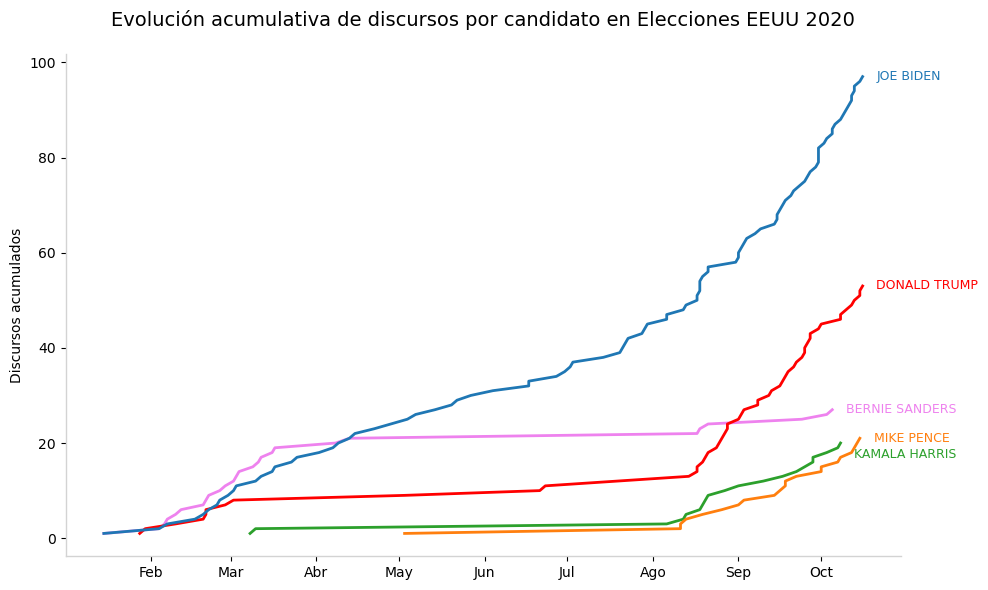

In [32]:
# CREO GRAFICO

# 1) Reúne todos los DF_fecha_candidatoN en una lista
dfs = [
    DF_fecha_candidato1,
    DF_fecha_candidato2,
    DF_fecha_candidato3,
    DF_fecha_candidato4,
    DF_fecha_candidato5
]

# 2) Concatenar
df_all = pd.concat(dfs, ignore_index=True)

# 3) Asegurar que 'date' es datetime
df_all['date'] = pd.to_datetime(df_all['date'])

# 4) Ordenar por fecha y calcular la cuenta acumulada por candidato
df_all = df_all.sort_values('date')
df_all['cumulative'] = df_all.groupby('candidato').cumcount() + 1


# 5) Plot acumulativo con etiquetas al final en mayúsculas

# Colores personalizados
color_map = {
    'donald trump'  : 'red',
    'mike pence'    : '#ff7f0e',
    'joe biden'     : '#1f77b4',
    'bernie sanders': 'violet',
    'kamala harris' : '#2ca02c'
}

# Graficar líneas y capturar etiquetas
fig, ax = plt.subplots(figsize=(10, 6))
labels = []
for candidato, grupo in df_all.groupby('candidato'):
    line, = ax.plot(
        grupo['date'], grupo['cumulative'],
        label=candidato.upper(),
        color=color_map[candidato],
        linewidth=2
    )
    x_last = grupo['date'].iloc[-1] + pd.Timedelta(days=5)
    y_last = grupo['cumulative'].iloc[-1]
    txt = ax.text(
        x_last, y_last, candidato.upper(),
        color=line.get_color(), va='center',
     fontsize=9
    )
    labels.append(txt)


# Bajar manualmente la etiqueta de Kamala Harris
for txt in labels:
    if txt.get_text() == 'KAMALA HARRIS':
        x, y = txt.get_position()
        txt.set_position((x, y - 2.5))  # baja 1 unidad en Y (ajusta el valor según convenga)
        break


# Formato del eje X
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xticklabels(['Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov'])

# Eje Y: etiqueta en negro, sin rayitas ni números
ax.set_ylabel('Discursos acumulados', color='black')


# Spines en gris claro
for spine in ['bottom','left']:
    ax.spines[spine].set_color('lightgray')
    ax.spines[spine].set_linewidth(1.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Título
ax.set_title(
    'Evolución acumulativa de discursos por candidato en Elecciones EEUU 2020',
    fontsize=14, pad=20
)

plt.tight_layout()
plt.show()


## Análisis cualitativo de la gráfica de discursos acumulados
El gráfico muestra cómo evoluciona la cantidad acumulada de discursos de cada candidato a lo largo del 2020. Se observan patrones interesantes: 

### Joe Biden  
La curva de Biden (azul) comienza en niveles bajos a fines de enero, e incrementa moderadamente hasta julio, con una pendiente constante, lo que indica un ritmo estable de discursos. A partir de agosto, la pendiente se eleva gradualmente y se dispara notablemente en septiembre, mostrando un fuerte aumento en la frecuencia de discursos hacia el inicio tradicional de la temporada electoral en Estados Unidos. Biden finaliza con el mayor acumulado de discursos, superando ampliamente al resto de candidatos.

### Donald Trump  
La curva de Trump (rojo) es casi horizontal desde febrero hasta mediados de agosto, indicando muy pocos discursos acumulados en ese período. A partir de principios de septiembre, comienza un incremento abrupto en la pendiente, con una pronunciada subida continua durante septiembre y octubre. Trump intensificó drásticamente sus discursos en el último mes de campaña electoral, pareciendo tomar una estrategia de campaña distinta a la de Biden.

### Bernie Sanders  
La curva de Sanders (rosa) muestra un crecimiento fuerte en febrero y marzo, con una pendiente pronunciada al inicio de la gráfica. Esto refleja su alta actividad durante las primarias demócratas de 2020. La curva se aplana drásticamente a partir de la primera semana de abril, tras perder las primarias con Joe Biden. Esta curva se mantiene casi horizontal hasta finales de agosto, donde se observa una ligera reactivación con un pequeño aumento, lo cual podría indicar alguna participación en discursos apoyando a los demócratas. Aun así, comparativamente, Sanders acumuló más discursos que Harris y Pence al final de la campaña.

### Kamala Harris  
La curva de Harris (naranja) permanece prácticamente horizontal desde enero hasta mediados de agosto, indicando muy escasa actividad en discursos acumulados. A finales de agosto o principios de septiembre, la pendiente empieza a aumentar moderadamente como resultado de haber sido elegida como vicepresidenta en la fórmula presidencial de los demócratas.

### Mike Pence  
La curva de Pence, candidato a la vicepresidencia republicano (verde), es similar a la de Harris: prácticamente plana hasta agosto, seguida de un pronunciado cambio a principios de septiembre. A partir de esa fecha, Pence incrementa su pendiente y acumula discursos de forma creciente durante septiembre y octubre.

### Observaciones generales  
Todas las curvas reflejan una aceleración de discursos a partir de mediados de agosto de 2020, momento en el que comienza formalmente la campaña electoral. Joe Biden (azul) es el candidato con mayor número acumulado y, a comparación de los demás candidatos, su curva muestra una presencia creciente y constante durante todo el año.

Resulta interesante notar que, si se compara la pendiente de las curvas (cantidad de discursos por unidad de tiempo) entre fines de agosto y octubre, se observa que la pendiente de los presidenciables es bastante similar, y la de los vicepresidenciables también. Siendo mucho mayor en los presidenciables que en los vicepresidenciables (visualmente, casi el doble de discursos por unidad de tiempo).

En resumen, la visualización permite identificar claramente los momentos clave en los que se intensifica la campaña de cada figura política, y resulta útil para entender las estrategias comunicacionales y sus tiempos.

### C. Una de las funciones básicas que se desea realizar, es el conteo de palabras: 

Cuántas veces aparece cada palabra agrupando por distintos criterios. Para ello, primero es
necesario normalizar el texto (i.e: pasarlo todo a minúsculas) y eliminar los signos de puntuación. De no hacerlo, las secuencias "You", "you." y “you,” se contarían como palabras distintas. La función clean_text(...) realiza parte de esta tarea, pero se debe completar agregando algunos signos de puntuación y cualquier otra normalización que considere oportuna. Comprobar el resultado observando el contenido de df_speeches_top_5, algunas celdas más abajo. Comente todas las transformaciones de texto que haya agregado y justifi que.

In [33]:
# Crear nueva columna con todos los oradores únicos por fila
oradores = DF_speaker_mas_text.copy()

# Generar columna con lista de strings únicos
oradores["oradores_finales"] = oradores.apply(
    lambda row: list({v for v in row if isinstance(v, str)}),
    axis=1
)

# Extraer solo la columna final, con el índice correcto
col_oradores_finales = oradores["oradores_finales"]

# Agregar resultado de oradores finales (oradores extraídos de speaker y de text))
df_speeches["oradores_finales"] = col_oradores_finales

# Visualizar
# df_speeches.head(10)

In [34]:
# Crear una nueva columna 'text1' con el texto normalizado (minusculas y nombres estandarizados o none)
df_speeches['text1'] = df_speeches['text'].apply(normalize_names)

# Visualizar
# df_speeches.head(10)

In [35]:
# Extrae el texto correspondiente a cada orador en una columna, para cada uno de los top 5 oradores.

def extraer_intervenciones_por_orador(texto, oradores_normalizados):
    
    # Si el contenido no es un string (por ejemplo, NaN), devolver diccionario con textos vacíos
    if not isinstance(texto, str):
        return {orador: "" for orador in oradores_normalizados}

    # Compilar patrón regex que detecta encabezados de intervenciones en el formato:
    # salto de línea + Nombre Apellido: (mm:ss) o (hh:mm:ss)
    # inicio de línea  + Nombre Apellido: (mm:ss) o (hh:mm:ss)
    patron = re.compile(r'(?:^|\n)([A-Za-z \.]+): \(\d{2}:\d{2}(?::\d{2})?\)', flags=re.MULTILINE)

    bloques = [] # Lista donde se guardarán tuplas (orador_normalizado, segmento de texto)
    matches = list(patron.finditer(texto)) # Buscar todos los encabezados que matcheen el patrón
 
    # Iterar sobre todos los encabezados encontrados
    for i in range(len(matches)):
        nombre_crudo = matches[i].group(1).strip().lower() # Extraer nombre crudo del encabezado
        nombre_crudo = normalize_names(nombre_crudo)  # Normalizar nombre (según reglas definidas)

        # Definir el segmento del texto que corresponde a esa intervención
        inicio = matches[i].start()
        fin = matches[i + 1].start() if i + 1 < len(matches) else len(texto)
        segmento = texto[inicio:fin].strip()

        bloques.append((nombre_crudo, segmento)) # Guardar orador y su fragmento de texto

    # Crear diccionario con oradores como claves y texto acumulado como valor inicial vacío
    resultado = {orador: "" for orador in oradores_normalizados}
    
    # Completar el diccionario sólo con los oradores indicados (top 5)
    for orador, fragmento in bloques:
        if orador in resultado:
            resultado[orador] += fragmento + "\n" # Acumular texto correspondiente al orador

    return resultado

# Obtener lista de los 5 oradores principales desde top_5_candidatos
top_5_oradores = top_5_candidatos['speaker'].tolist()

# Aplicar función de extracción a cada fila del DataFrame y expandir resultados como columnas nuevas
df_speeches[top_5_oradores] = df_speeches['text1'].apply(
    lambda t: pd.Series(extraer_intervenciones_por_orador(t, top_5_oradores))
)

# df_speeches.to_excel("df_speeches_con_texto_por_orador.xlsx", index=False)

# Visualizar
# df_speeches

In [36]:
# Crear un DataFrame con los discursos de los 5 candidatos más frecuentes
nombres_top_5 = top_5_candidatos['speaker'].tolist()

# Filtrar filas donde al menos uno de los nombres del top 5 aparece en la columna "oradores_finales"
df_speeches_top_5 = df_speeches[
    df_speeches["oradores_finales"].apply(lambda lista: any(orador in nombres_top_5 for orador in lista))
].copy()

# Revisar el shape
print(df_speeches.shape)
print(df_speeches_top_5.shape)

(269, 14)
(194, 14)


In [37]:
##  Toma como entrada las columnas con los discursos de los top 5 oradores, y reemplaz el nombre del orador : (MM:SS) por ' // '

def limpiar_encabezados(texto):
    """
    Reemplaza encabezados de orador (Ej. 'trump: (00:30)') por ' // '.
    
    """
    # Si el valor no es texto (por ejemplo, es NaN o None), lo deja sin cambios
    if not isinstance(texto, str):
        return texto
    
    # Busca patrones como "nombre apellido: (00:30)" o "(00:30:45)" y los reemplaza por " // "
    texto = re.sub(r'[A-Za-z \.]+: \(\d{2}:\d{2}(?::\d{2})?\)', 
                   ' // '           # texto por el que se reemplaza
                   , texto)

    return texto

# Aplica la función a las columnas de los top 5 oradores
for orador in top_5_oradores:
    df_speeches[orador] = df_speeches[orador].apply(limpiar_encabezados)

df_speeches_sin_encabezados = df_speeches.copy()

In [38]:
## AUXILIAR, CONTEO DE COLUMNAS NO NULAS PARA CADA CANDIDATO
# Lista de columnas de interés
cols = ['joe biden', 'donald trump', 'bernie sanders', 'mike pence', 'kamala harris']

# Para cada columna, contamos las celdas que no son NaN ni la cadena vacía
conteos = {
    col: df_speeches[col].notna() & (df_speeches[col].astype(str).str.strip() != '')
    for col in cols
}

# Sumamos True→1 a lo largo de cada Serie
result = {col: mask.sum() for col, mask in conteos.items()}

# Convertir a DataFrame para verlo bonito
AUX_CONTEO = pd.DataFrame.from_dict(
    result,
    orient='index',
    columns=['non_empty_count']
).reset_index().rename(columns={'index':'candidate'})

# Cantidad de discursos por candidato
print(AUX_CONTEO)

        candidate  non_empty_count
0       joe biden              101
1    donald trump               60
2  bernie sanders               27
3      mike pence               23
4   kamala harris               21


In [39]:
# Cuenta la cantidad de palabras de cada columna correspondiente a los top 5 oradores

def contar_palabras(texto):
    """
    Cuenta la cantidad de palabras en el texto.
    
    """
    # Verifica si el texto es una cadena válida; si no lo es, devuelve 0
    if not isinstance(texto, str):
        return 0
    
    # Elimina espacios al principio y al final y divide el texto en palabras usando espacios como separadores
    palabras = texto.strip().split()

    # Retorna la cantidad de palabras encontradas
    return len(palabras)

# Calcular el total de palabras por orador
conteo_palabras = {}

for orador in top_5_oradores:
    total = df_speeches[orador].apply(contar_palabras).sum()
    conteo_palabras[orador] = total

# Ordenar de mayor a menor
ranking = sorted(conteo_palabras.items(), key=lambda x: x[1], reverse=True)

# Mostrar el ranking
print("\nRanking de oradores por cantidad de palabras:\n")
for i, (orador, total) in enumerate(ranking, 1):
    print(f"{i}°: {orador} con {total} palabras.")


Ranking de oradores por cantidad de palabras:

1°: donald trump con 496105 palabras.
2°: joe biden con 343438 palabras.
3°: mike pence con 99700 palabras.
4°: bernie sanders con 65893 palabras.
5°: kamala harris con 44197 palabras.


In [40]:
# Creación de clean_text acorde a mis necesidades

def clean_text(df, column_name):
    """
    Normaliza texto eliminando encabezados, puntuación, tildes y convirtiendo a minúsculas.
    Esto permite un conteo de palabras consistente.
    """
    result = df[column_name]

    # 1. Eliminar cualquier encabezado hasta el primer salto de línea
    # Justificación: Muchas transcripciones comienzan con metadatos irrelevantes como "TRUMP: (00:30)"
    result = result.str.replace(r"^[^\n]*\n", "", regex=True)

    # 2. Convertir todo a minúsculas
    # Justificación: Para que "You", "you", "YOU" se cuenten como la misma palabra
    result = result.str.lower()

    # 3. Eliminar acentos (tildes) y caracteres diacríticos
    # Justificación: Para unificar palabras como “señor” y “senor”
    result = result.apply(lambda x: unicodedata.normalize("NFKD", x).encode("ASCII", "ignore").decode("utf-8") if isinstance(x, str) else x)

    # 4. Reemplazar signos de puntuación por espacios
    # Justificación: Para evitar que "you.", "you,", "you!" se cuenten como palabras distintas
    # Se incluye un conjunto extendido de puntuación: comillas, guiones largos, etc.
    signos_extra = '“”‘’–—'
    tabla = str.maketrans(string.punctuation + signos_extra, ' ' * (len(string.punctuation) + len(signos_extra)))
    result = result.str.translate(tabla)

    # 5. Reemplazar múltiples espacios por uno solo y eliminar espacios laterales
    # Justificación: Limpieza final para evitar errores en tokenización
    result = result.str.replace(r'\s+', ' ', regex=True).str.strip()

    return result

In [41]:
# Define los 5 oradores principales.
# Filtra las columnas del DataFrame que correspondan a esos oradores.
# Cuenta cuántas intervenciones tiene cada orador.
# Crea un nuevo DataFrame (DISCURSOS_TOTALES) con el nombre del orador y la cantidad total de discursos.

# Lista de oradores principales
top_5_oradores = ['joe biden', 'donald trump', 'bernie sanders', 'mike pence', 'kamala harris']

# 1) Filtrar solo las columnas que estén en top_5_oradores
columnas_oradores_presentes = [col for col in df_speeches_sin_encabezados.columns 
                               if col in top_5_oradores]

# 2) Calcular la suma de valores no vacíos por cada una
#    Aquí asumimos que cada celda con discurso es no nula; si son booleanos o 1/0, sum() sirve directamente.
#    Si necesitas contar no-null, usa .notna().sum()
totales = []
for col in columnas_oradores_presentes:
    # Si quisieras contar filas no nulas:
    # total = df_speeches_sin_encabezados[col].notna().sum()
    # Si las celdas son 1/0, entonces:
    total = df_speeches_sin_encabezados[col].sum()
    totales.append(total)

# 3) Construir el DataFrame de salida
DISCURSOS_TOTALES = pd.DataFrame(
    [columnas_oradores_presentes, totales],
    index=['candidato', 'total_discursos']
).T.reset_index(drop=True)

# Resultado: DISCURSOS_TOTALES con columnas ['candidato','total_discursos']
print(DISCURSOS_TOTALES)

DISCURSOS_TOTALES.iloc[:, 1] = clean_text(DISCURSOS_TOTALES, DISCURSOS_TOTALES.columns[1]) 
DISCURSOS_TOTALES['WordList'] = DISCURSOS_TOTALES.iloc[:, 1].str.split()

        candidato                                    total_discursos
0       joe biden   // \nhello, michigan. hi, how are you? what’s...
1    donald trump   // \nthank you. what a nice group. thank you ...
2  bernie sanders   // \nbut if these were normal times, and we w...
3      mike pence   // \nthank you so much.\n // \ni’ll give it t...
4   kamala harris   // \nhey everybody. hi. where’s vanessa? wher...


In [42]:
#10 PALABRAS MAS COMUNES POR CANDIDATO 

 #Partimos de DISCURSOS_TOTALES con columnas:
#   'candidato'    (ej. 'joe biden', 'donald trump', …)
#   'WordList'     (lista de palabras limpias por fila)

# 1) Explode: crear un DataFrame con una fila por (candidato, palabra)
df_exploded = DISCURSOS_TOTALES.explode('WordList')

# 2) Contar frecuencias por candidato y palabra
df_counts = (
    df_exploded
    .groupby(['candidato', 'WordList'])
    .size()
    .reset_index(name='count')
)

# 3) Para cada candidato, tomar top 10
top10_por_candidato = (
    df_counts
    .sort_values(['candidato', 'count'], ascending=[True, False])
    .groupby('candidato')
    .head(10)
    .reset_index(drop=True)
)

# 4) Ver resultado
# for cand in top10_por_candidato['candidato'].unique():
#     print(f"\nTop 10 palabras para {cand}:")
#     display(top10_por_candidato[top10_por_candidato['candidato']==cand])

In [43]:
#PALABRAS POSITIVAS 
# Lista de las 10 palabras positivas
positivas = [
    "hope", "change", "unity", "freedom", "justice",
    "peace", "opportunity", "prosperity", "kindness", "love"
]

# 1) Filtrar solo las filas con palabras positivas
df_positivas = df_exploded[df_exploded['WordList'].isin(positivas)].copy()

# 2) Contar apariciones de cada (palabra, candidato)
df_counts = (
    df_positivas
    .groupby(['WordList', 'candidato'])
    .size()
    .reset_index(name='count')
)

# 3) Pivotar para tener en filas las palabras y en columnas los candidatos
DISCURSOS_POSITIVAS = df_counts.pivot_table(
    index='WordList',
    columns='candidato',
    values='count',
    fill_value=0
).reset_index()

# 4) Si quieres renombrar la columna índice
DISCURSOS_POSITIVAS = DISCURSOS_POSITIVAS.rename(columns={'WordList': 'palabra'})

# ———> Línea añadida: ajustar encabezados
DISCURSOS_POSITIVAS.columns = ['PALABRAS POSITIVAS'] + list(DISCURSOS_POSITIVAS.columns[1:])

# print(DISCURSOS_POSITIVAS)

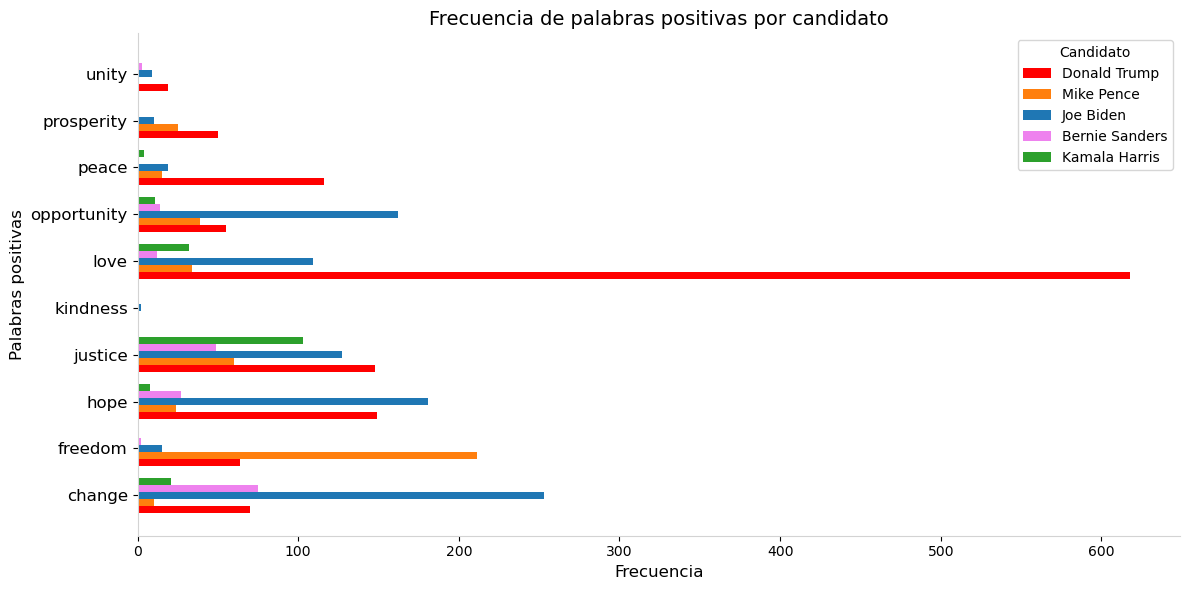

In [44]:
## GRAFICO PALABRAS POSITIVAS 
# 1) Renombrar la columna para que se llame 'palabra'
DISCURSOS_POSITIVAS = DISCURSOS_POSITIVAS.rename(columns={'PALABRAS POSITIVAS': 'palabra'})

# 2) Preparar el eje Y y la altura de las barras (ancho original)
y = np.arange(len(DISCURSOS_POSITIVAS['palabra']))
height = 0.15

# 3) Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# 4) Definir el mapa de colores personalizado
color_map = {
    'donald trump'  : 'red',
    'mike pence'    : '#ff7f0e',
    'joe biden'     : '#1f77b4',
    'bernie sanders': 'violet',
    'kamala harris' : '#2ca02c'
}

# 5) Bucle para plotear cada candidato
for i, candidato in enumerate(color_map.keys()):
    ax.barh(
        y + i * height,
        DISCURSOS_POSITIVAS[candidato],
        height=height,
        label=candidato.title(),
        color=color_map[candidato]
    )

# 6) Etiquetas y leyenda
ax.set_yticks(y + height * (len(color_map) - 1) / 2)
ax.set_yticklabels(DISCURSOS_POSITIVAS['palabra'], fontsize=12)
ax.set_xlabel('Frecuencia', fontsize=12)
ax.set_ylabel('Palabras positivas', fontsize=12)
ax.set_title('Frecuencia de palabras positivas por candidato', fontsize=14)
ax.legend(title='Candidato')

# 7) Ocultar ejes derecho y superior, y pintar inferior/izquierdo en gris claro
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_color('lightgray')

plt.tight_layout()
plt.show()

In [45]:
## PALABRAS NEGATIVAS 

# Lista de las 10 palabras negativas
negativas = [
    "crisis", "chaos", "broken", "dysfunctional", "corruption",
    "poverty", "unemployment", "coronavirus", "terror", "messy"
]

# 1) Filtrar solo las filas con palabras negativas
df_negativas = df_exploded[df_exploded['WordList'].isin(negativas)].copy()

# 2) Contar apariciones de cada (palabra, candidato)
df_counts_neg = (
    df_negativas
    .groupby(['WordList', 'candidato'])
    .size()
    .reset_index(name='count')
)

# 3) Pivotar para tener en filas las palabras y en columnas los candidatos
DISCURSOS_NEGATIVAS = df_counts_neg.pivot_table(
    index='WordList',
    columns='candidato',
    values='count',
    fill_value=0
).reset_index()

# 4) Renombrar la columna índice
DISCURSOS_NEGATIVAS = DISCURSOS_NEGATIVAS.rename(columns={'WordList': 'palabra'})

# 5) Ajustar encabezados
DISCURSOS_NEGATIVAS.columns = ['PALABRAS NEGATIVAS'] + list(DISCURSOS_NEGATIVAS.columns[1:])

# print(DISCURSOS_NEGATIVAS)

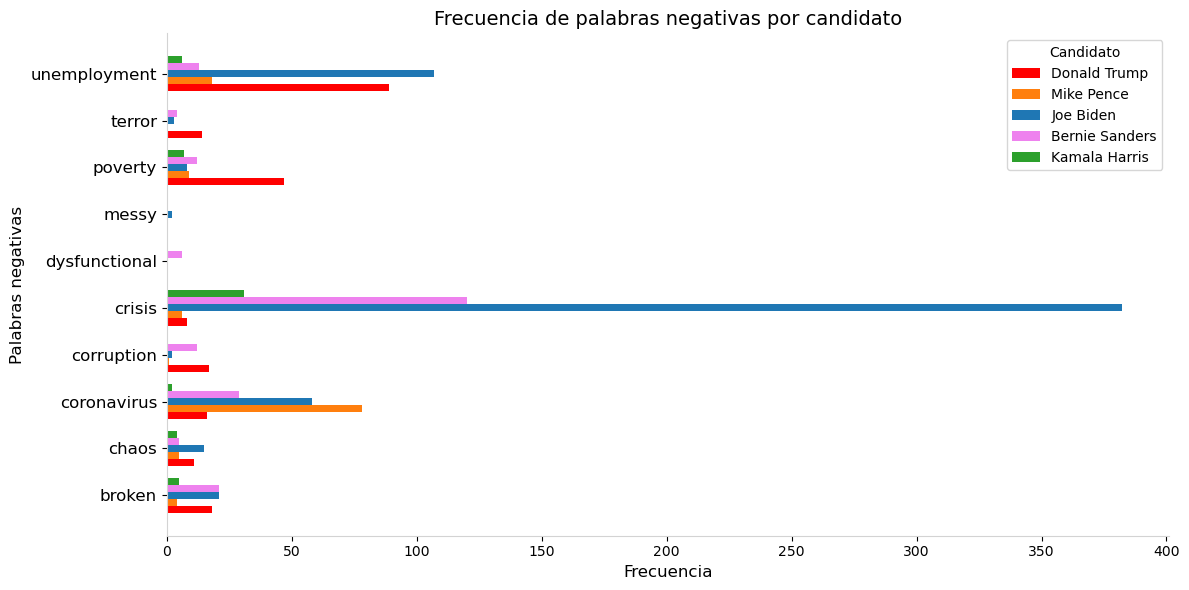

In [46]:
##GRAFICO PALABRAS NEGATIVAS 

# 1) Renombrar la columna para facilitar el acceso
DISCURSOS_NEGATIVAS = DISCURSOS_NEGATIVAS.rename(columns={'PALABRAS NEGATIVAS': 'palabra'})

# 2) Preparar el eje Y y la altura de las barras (ancho original)
y = np.arange(len(DISCURSOS_NEGATIVAS['palabra']))
height = 0.15

# 3) Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# 4) Definir el mapa de colores personalizado
color_map = {
    'donald trump'  : 'red',
    'mike pence'    : '#ff7f0e',
    'joe biden'     : '#1f77b4',
    'bernie sanders': 'violet',
    'kamala harris' : '#2ca02c'
}

# 5) Bucle para plotear cada candidato
for i, candidato in enumerate(color_map.keys()):
    ax.barh(
        y + i * height,
        DISCURSOS_NEGATIVAS[candidato],
        height=height,
        label=candidato.title(),
        color=color_map[candidato]
    )

# 6) Etiquetas y leyenda
ax.set_yticks(y + height * (len(color_map) - 1) / 2)
ax.set_yticklabels(DISCURSOS_NEGATIVAS['palabra'], fontsize=12)
ax.set_xlabel('Frecuencia', fontsize=12)
ax.set_ylabel('Palabras negativas', fontsize=12)
ax.set_title('Frecuencia de palabras negativas por candidato', fontsize=14)
ax.legend(title='Candidato')

# 7) Ocultar ejes derecho y superior, y pintar inferior/izquierdo en gris claro
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_color('lightgray')

plt.tight_layout()
plt.show()

In [47]:
## Diversidad Léxica 
# (Diversidad léxica = (número de palabras únicas) / (número total de palabras))
# 2. Eliminar palabras con longitud menor o igual a 3 (opcional, para excluir monosílabos)

# Diccionario de colores
color_map = {
    'donald trump'  : 'red',
    'mike pence'    : '#ff7f0e',
    'joe biden'     : '#1f77b4',
    'bernie sanders': 'violet',
    'kamala harris' : '#2ca02c'
}

# Asegurarse que WordList sea lista (convertir desde string si es necesario)
DISCURSOS_TOTALES['WordList'] = DISCURSOS_TOTALES['WordList'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Calcular diversidad léxica relativa por candidato
lexico = {}

for _, row in DISCURSOS_TOTALES.iterrows():
    candidato = row['candidato'].lower()
    palabras = [p.lower() for p in row['WordList'] if len(p) >= 3]
    
    if candidato not in lexico:
        lexico[candidato] = {'total': 0, 'unicas': set()}
    
    lexico[candidato]['total'] += len(palabras)
    lexico[candidato]['unicas'].update(palabras)

# Crear DataFrame con razón de diversidad léxica
data = []
for candidato, datos in lexico.items():
    total = datos['total']
    distintas = len(datos['unicas'])
    ratio = distintas / total if total > 0 else 0
    data.append((candidato, ratio))

df_lexico = pd.DataFrame(data, columns=['Candidato', 'Diversidad léxica'])

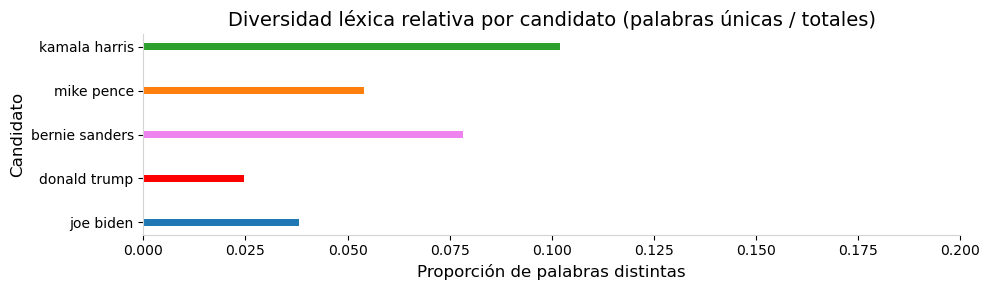

In [48]:
# Gráfico DIVERSIDAD LEXICA
# Prepara los datos
# Definir el mapa de colores personalizado
color_map = {
    'donald trump'  : 'red',
    'mike pence'    : '#ff7f0e',
    'joe biden'     : '#1f77b4',
    'bernie sanders': 'violet',
    'kamala harris' : '#2ca02c'
}

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 3))

# Crear el gráfico de barras horizontal (ancho original)
ax.barh(
    df_lexico['Candidato'],
    df_lexico['Diversidad léxica'],
    height=0.15,
    color=[color_map.get(c.lower(), 'gray') for c in df_lexico['Candidato']]
)

# Añadir título y etiquetas
ax.set_title('Diversidad léxica relativa por candidato (palabras únicas / totales)', fontsize=14)
ax.set_xlabel('Proporción de palabras distintas', fontsize=12)
ax.set_ylabel('Candidato', fontsize=12)
ax.set_xlim(0, 0.2)  # Ajustar el límite del eje X según tus datos

# Ocultar ejes derecho y superior, y pintar inferior/izquierdo en gris claro
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_color('lightgray')

plt.tight_layout()
plt.show()

# Limpieza de Texto y Conteo de Palabras

## Parte 2: Conteo de Palabras y Visualizaciones

 ## Candidatos con mayor cantidad de palabras

### A. Realice una visualización que permita comparar las palabras más frecuentes de cada uno de los cinco candidatos/as. Sin necesidad de implementarlo, proponga ideas para modificar esta visualización con el fin de encontrar diferencias entre partidos políticos, fechas, o lugares.

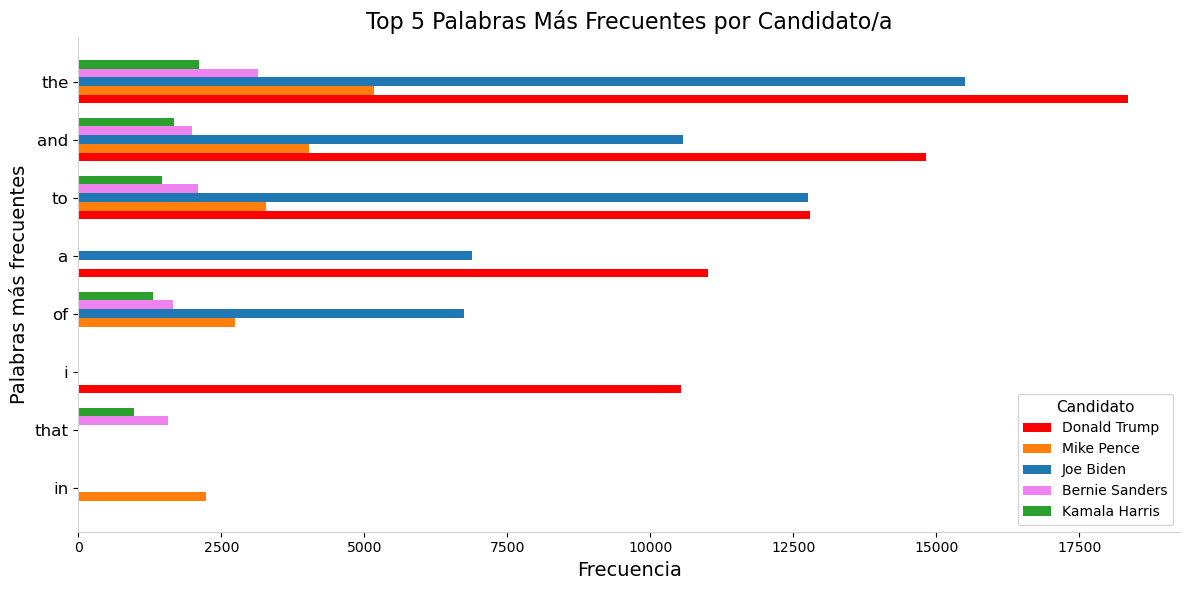

In [65]:
# TODO: Realice una visualización que permita comparar las palabras más frecuentes de cada uno de los cinco candidatos/as. 

# Crear lista vacía para acumular resultados
lista_frecuencias = []

# Recorrer cada fila de DISCURSOS_TOTALES
for _, row in DISCURSOS_TOTALES.iterrows():
    candidato = row['candidato']
    palabras = row['WordList']
    conteo = Counter(palabras).most_common(5)

    for palabra, frecuencia in conteo:
        lista_frecuencias.append({
            "palabra": palabra,
            "frecuencia": frecuencia,
            "candidato": candidato
        })

# Crear DataFrame
df_frecuencias = pd.DataFrame(lista_frecuencias)

# Agrupar por palabra para calcular el total y ordenar
orden_palabras = (
    df_frecuencias.groupby('palabra')['frecuencia']
    .sum()
    .sort_values(ascending=True)
    .index
)

palabras_ordenadas = list(orden_palabras)
y = np.arange(len(palabras_ordenadas))
height = 0.15

# Definir el mapa de colores personalizado
color_map = {
    'donald trump'  : 'red',
    'mike pence'    : '#ff7f0e',
    'joe biden'     : '#1f77b4',
    'bernie sanders': 'violet',
    'kamala harris' : '#2ca02c'
}

# Crear figura
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar una barra por cada candidato
for i, candidato in enumerate(color_map.keys()):
    valores = []

    for palabra in palabras_ordenadas:
        fila = df_frecuencias[(df_frecuencias['palabra'] == palabra) & (df_frecuencias['candidato'] == candidato)]
        frecuencia = fila['frecuencia'].values[0] if not fila.empty else 0
        valores.append(frecuencia)

    ax.barh(
        y + i * height,
        valores,
        height=height,
        label=candidato.title(),
        color=color_map[candidato]
    )

# Etiquetas y estilo
ax.set_yticks(y + height * (len(color_map) - 1) / 2)
ax.set_yticklabels(palabras_ordenadas, fontsize=12)
ax.set_xlabel('Frecuencia', fontsize=14)
ax.set_ylabel('Palabras más frecuentes', fontsize=14)
ax.set_title('Top 5 Palabras Más Frecuentes por Candidato/a', fontsize=16)
ax.legend(title='Candidato', fontsize=10, title_fontsize=11)

# Estética del gráfico
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_color('lightgray')

plt.tight_layout()
plt.show()

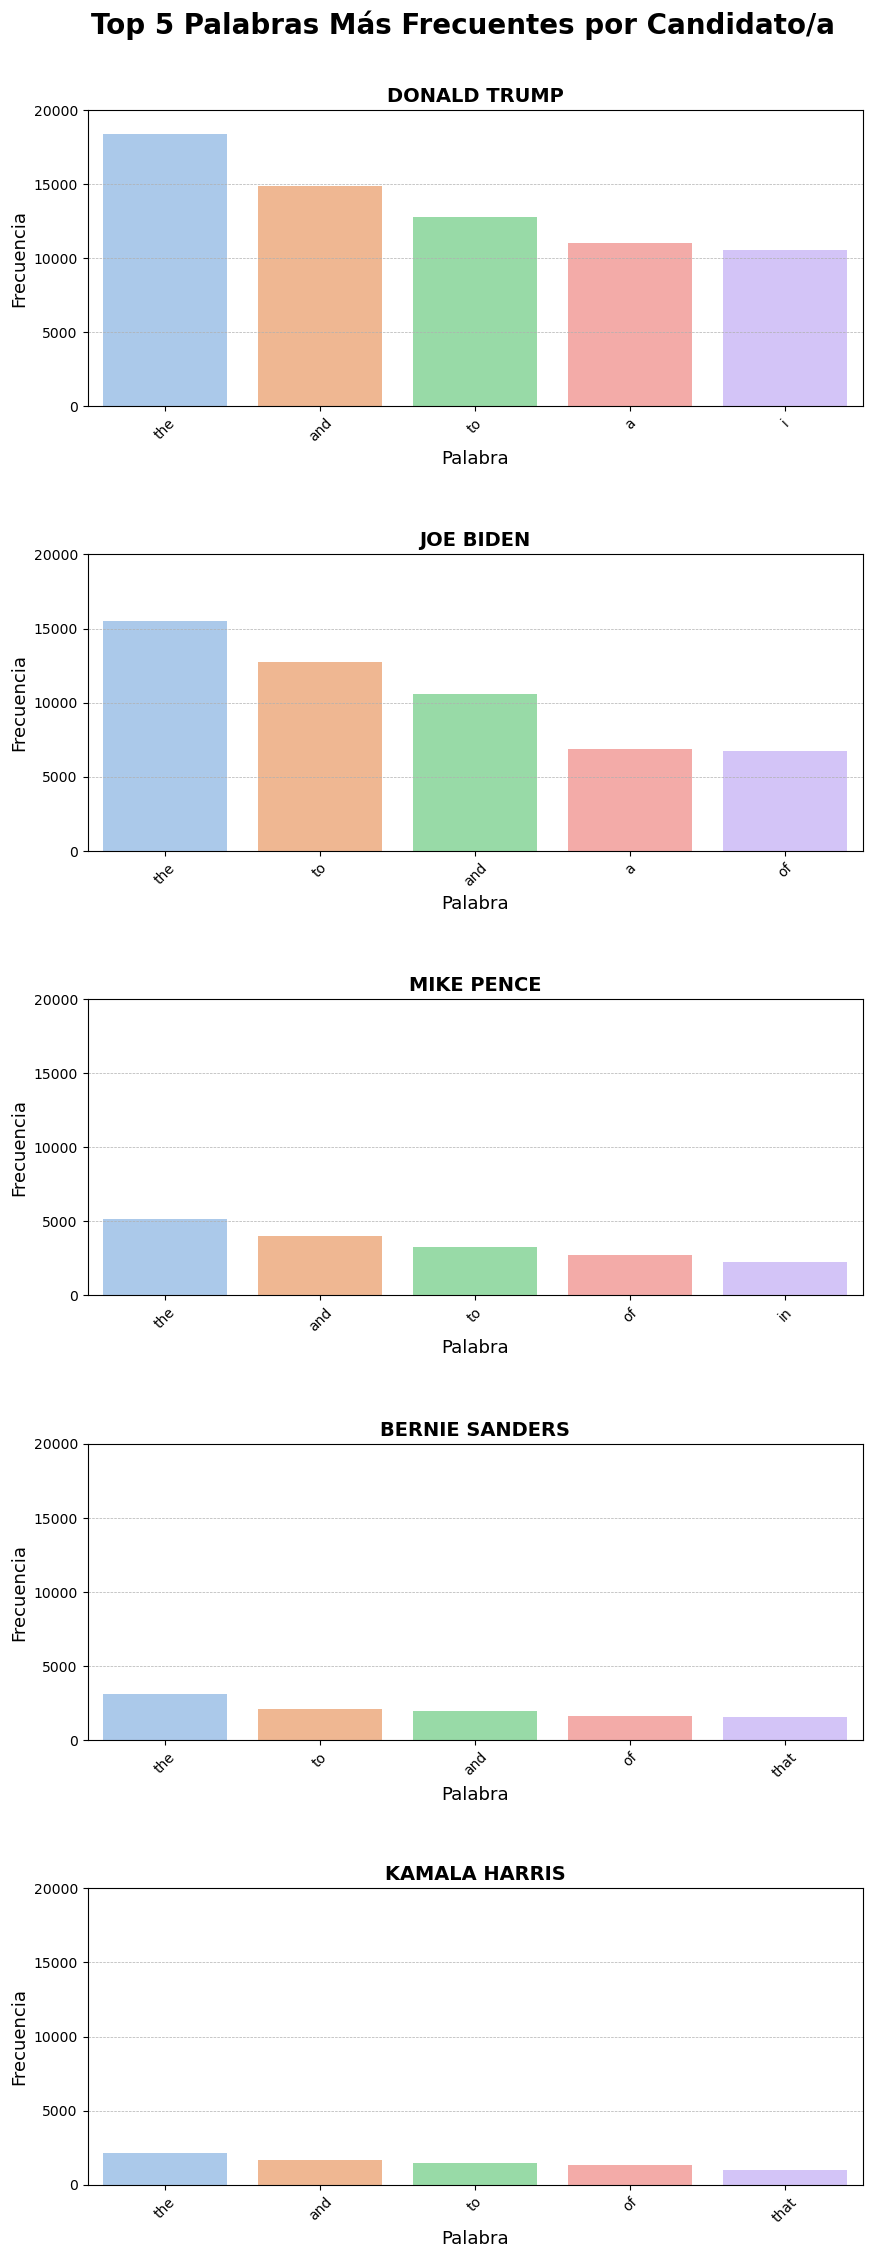

In [ ]:
# Orden personalizado de candidatos
orden_candidatos = ['donald trump', 'joe biden', 'mike pence', 'bernie sanders', 'kamala harris']
df_frecuencias['candidato'] = df_frecuencias['candidato'].str.lower()
df_frecuencias['candidato'] = pd.Categorical(df_frecuencias['candidato'], categories=orden_candidatos, ordered=True)

# Crear los subplots (5 filas, 1 columna)
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 25), sharex=False)

# Definir rango fijo para el eje Y (máximo general)
y_max = 20000
y_ticks = np.arange(0, y_max + 1, 5000)

for i, candidato in enumerate(orden_candidatos):
    datos = df_frecuencias[df_frecuencias['candidato'] == candidato].sort_values("frecuencia", ascending=False)
    ax = axes[i]

    sns.barplot(data=datos, x="palabra", y="frecuencia", ax=ax, palette="pastel")

    ax.set_title(candidato.upper(), fontsize=14, fontweight='bold')
    ax.set_xlabel("Palabra", fontsize=13)
    ax.set_ylabel("Frecuencia", fontsize=13)
    ax.tick_params(axis='x', rotation=45)
    ax.set_yticks(y_ticks)
    ax.set_ylim(0, y_max)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Título general
fig.suptitle("Top 5 Palabras Más Frecuentes por Candidato/a", fontsize=20, fontweight='bold')

# Aumentar espacio entre gráficos
plt.subplots_adjust(hspace=0.5, top=0.94)
plt.show()


## ¿Encuentra algún problema en los resultados?

Sí. El primer gráfico muestra las palabras más frecuentes de cada candidato, pero muchas de estas son palabras vacías (stopwords) como "the", "to", "and", "i", etc. Estas palabras son tan comunes en el idioma que no aportan información relevante para distinguir estilos discursivos o temáticas de cada orador.

Por eso, se construyó un segundo gráfico eliminando estas stopwords, lo que permite observar con más claridad qué conceptos, personajes o ideas son más mencionados por cada candidato.

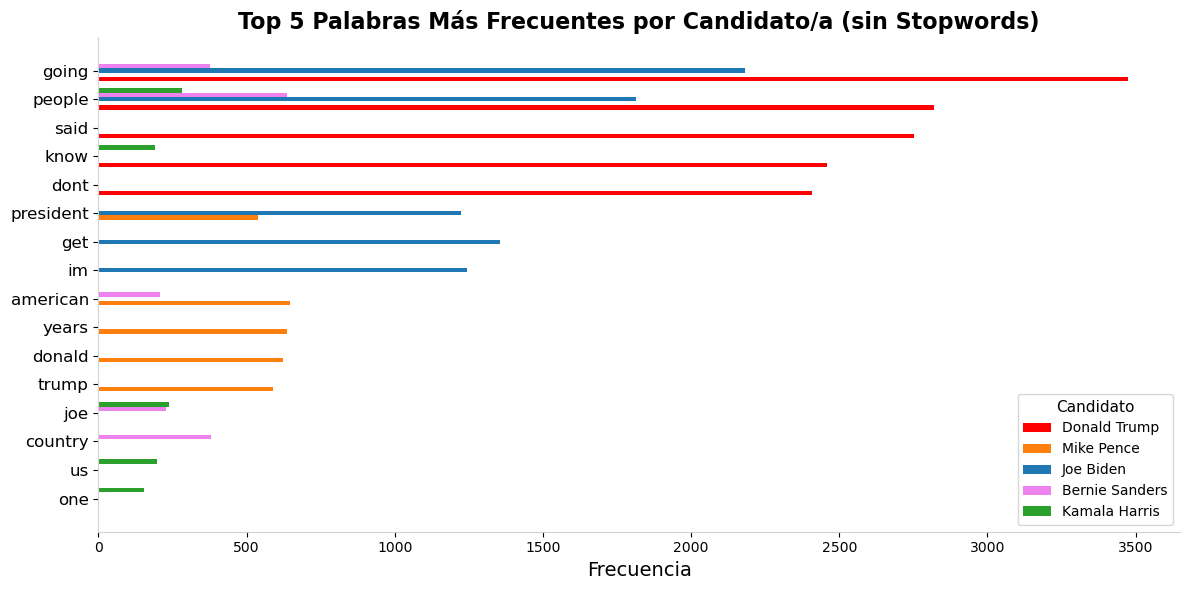

In [72]:
# Eliminar las stop words y volver a contar
# Graficar el top 5 palabras por orador sin stopwords

# Definir stopwords en inglés
stop_words = set(stopwords.words('english'))

# Crear lista vacía para acumular resultados sin stopwords
lista_frecuencias_clean = []

# Recorrer cada fila de DISCURSOS_TOTALES
for _, row in DISCURSOS_TOTALES.iterrows():
    candidato = row['candidato']
    palabras = row['WordList']

    # Filtrar stopwords
    palabras_filtradas = [word for word in palabras if word.lower() not in stop_words]

    # Contar top 5 palabras
    conteo = Counter(palabras_filtradas).most_common(5)

    for palabra, frecuencia in conteo:
        lista_frecuencias_clean.append({
            "palabra": palabra,
            "frecuencia": frecuencia,
            "candidato": candidato.lower()
        })

# Crear DataFrame
df_frecuencias_clean = pd.DataFrame(lista_frecuencias_clean)

# Agrupar por palabra para calcular el total y ordenar
orden_palabras = (
    df_frecuencias_clean.groupby('palabra')['frecuencia']
    .sum()
    .sort_values(ascending=True)
    .index
)

palabras_ordenadas = list(orden_palabras)
y = np.arange(len(palabras_ordenadas))
height = 0.15

# Definir el mapa de colores personalizado
color_map = {
    'donald trump'  : 'red',
    'mike pence'    : '#ff7f0e',
    'joe biden'     : '#1f77b4',
    'bernie sanders': 'violet',
    'kamala harris' : '#2ca02c'
}

# Crear figura
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar una barra por cada candidato
for i, candidato in enumerate(color_map.keys()):
    valores = []

    for palabra in palabras_ordenadas:
        fila = df_frecuencias_clean[
            (df_frecuencias_clean['palabra'] == palabra) &
            (df_frecuencias_clean['candidato'] == candidato)
        ]
        frecuencia = fila['frecuencia'].values[0] if not fila.empty else 0
        valores.append(frecuencia)

    ax.barh(
        y + i * height,
        valores,
        height=height,
        label=candidato.title(),
        color=color_map[candidato]
    )

# Etiquetas y estilo
ax.set_yticks(y + height * (len(color_map) - 1) / 2)
ax.set_yticklabels(palabras_ordenadas, fontsize=12)
ax.set_xlabel('Frecuencia', fontsize=14)
# ax.set_ylabel('Palabras', fontsize=14)
ax.set_title('Top 5 Palabras Más Frecuentes por Candidato/a (sin Stopwords)', fontsize=16, fontweight='bold')
ax.legend(title='Candidato', fontsize=10, title_fontsize=11)

# Estética del gráfico
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_color('lightgray')

plt.tight_layout()
plt.show()

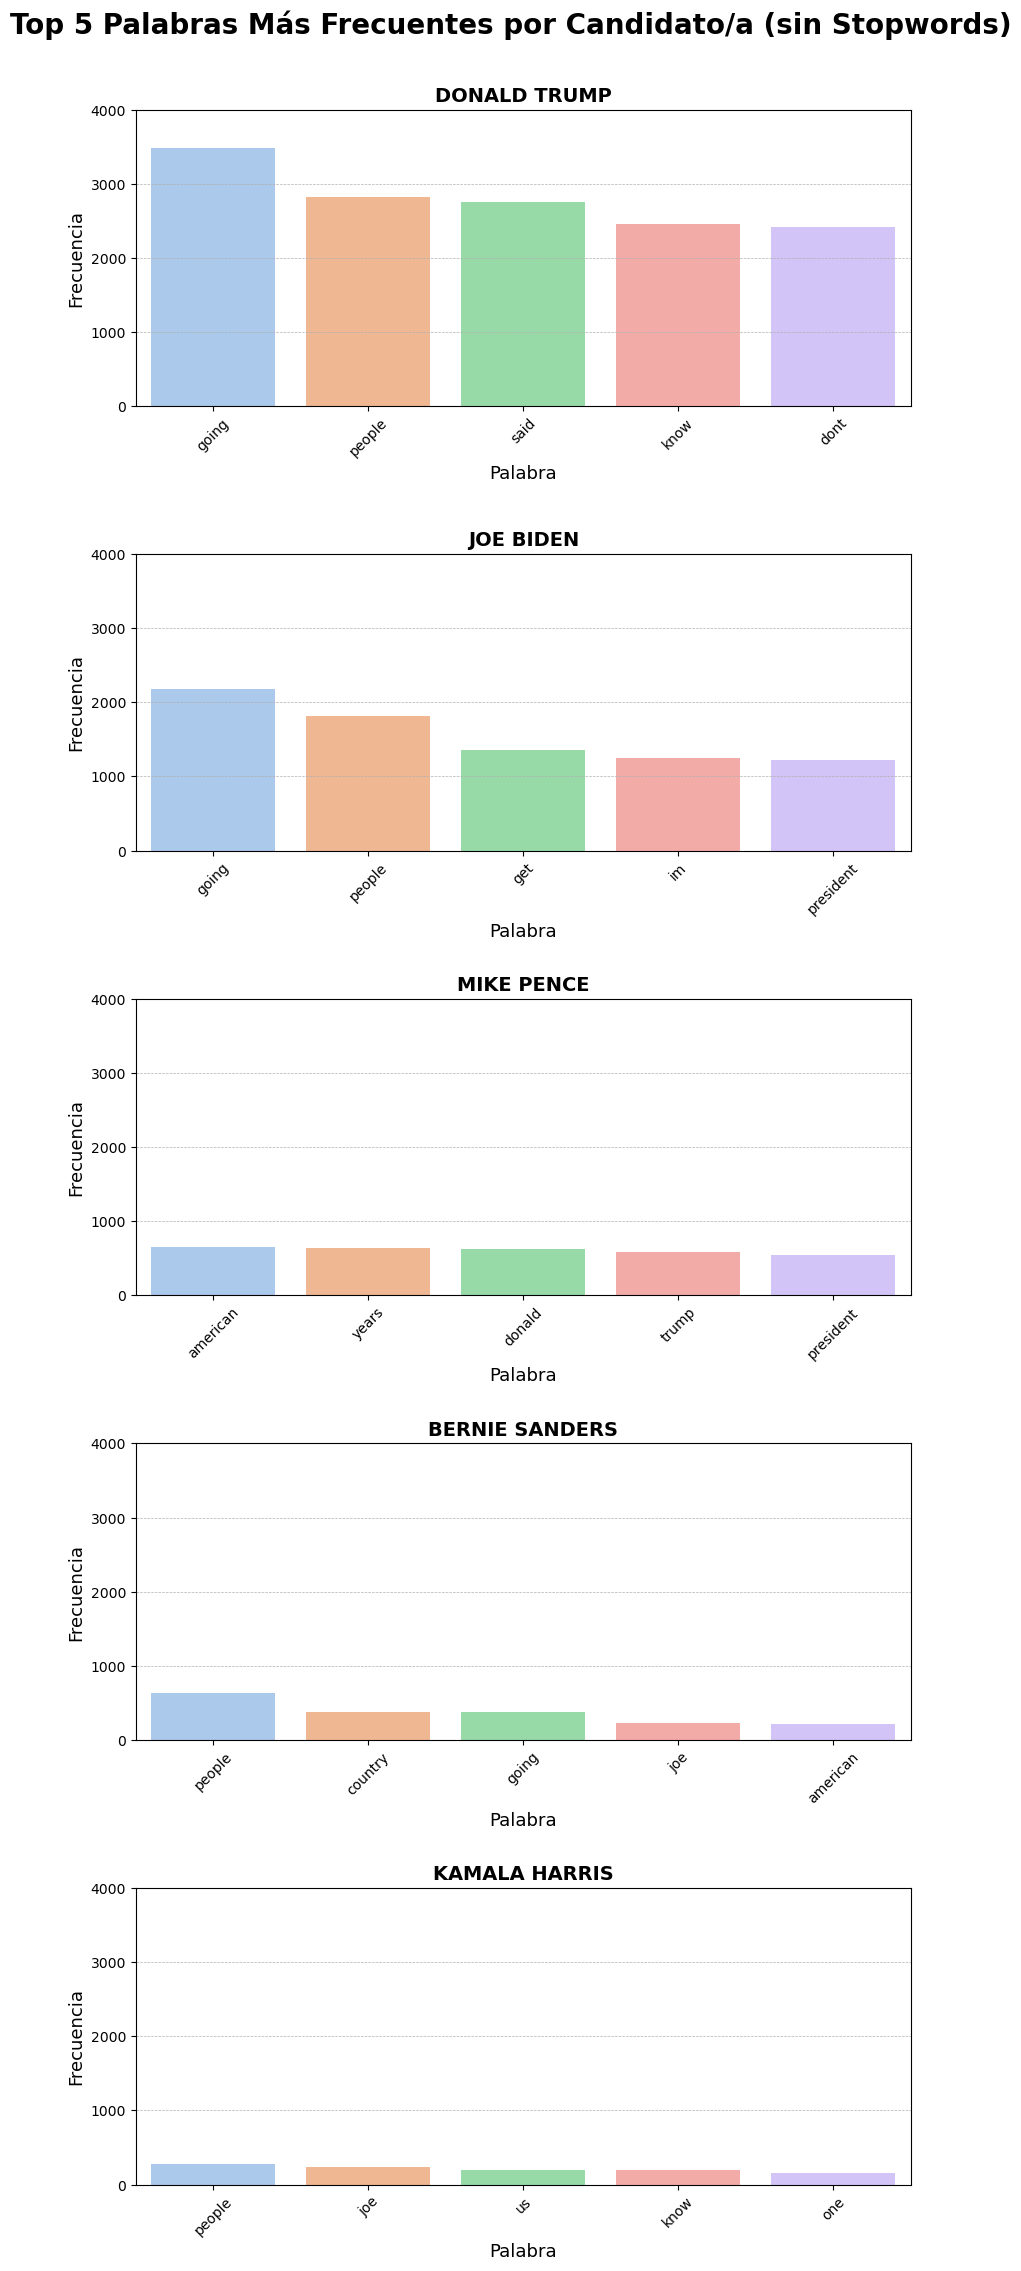

In [75]:
# Orden deseado de los candidatos
orden_candidatos = ['donald trump', 'joe biden', 'mike pence', 'bernie sanders', 'kamala harris']
df_frecuencias_clean['candidato'] = df_frecuencias_clean['candidato'].str.lower()
df_frecuencias_clean['candidato'] = pd.Categorical(df_frecuencias_clean['candidato'], categories=orden_candidatos, ordered=True)

# Crear subplots en filas
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 25), sharex=False)

# Rango fijo para el eje Y
y_max = 4000
y_ticks = np.arange(0, y_max + 1, 1000)

# Graficar por candidato
for i, candidato in enumerate(orden_candidatos):
    datos = df_frecuencias_clean[df_frecuencias_clean['candidato'] == candidato].sort_values("frecuencia", ascending=False)
    ax = axes[i]

    sns.barplot(data=datos, x="palabra", y="frecuencia", ax=ax, palette="pastel")

    ax.set_title(candidato.upper(), fontsize=14, fontweight='bold')
    ax.set_xlabel("Palabra", fontsize=13)
    ax.set_ylabel("Frecuencia", fontsize=13)
    ax.tick_params(axis='x', rotation=45)
    ax.set_yticks(y_ticks)
    ax.set_ylim(0, y_max)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Título general
fig.suptitle("Top 5 Palabras Más Frecuentes por Candidato/a (sin Stopwords)", fontsize=20, fontweight='bold')

# Espaciado entre subplots y título
plt.subplots_adjust(hspace=0.5, top=0.94)
plt.show()


##### Gráfico 2: Palabras más representativas por candidato (sin stopwords)

Este gráfico mejora la interpretabilidad, ya que expone palabras con mayor carga informativa. Se observan algunos patrones interesantes:

    - Referencias cruzadas entre candidatos**: varios oradores mencionan a otros dentro de su top 5 de palabras. Por ejemplo, *Kamala Harris* menciona a *Joe*, *Bernie Sanders* a *Joe*, y *Mike Pence* a *Donald* y *Trump*.

    - **Temas comunes**: palabras como *"people"*, *"going"*, *"american"* y *"president"* aparecen de forma recurrente en varios discursos, lo que indica un enfoque compartido en ciertas temáticas.

    - Tener en cuenta que una limitación del gráfico es que solo muestra el top 5 palabras por candidato. Palabras importantes, pero en menor frecuencia relativa, pueden quedar fuera del análisis.

### Ideas para modificar esta visualización con el fin de encontrar diferencias por partido político, fecha o lugar:

Además de contar palabras absolutas, una opción más informativa sería analizar la **frecuencia relativa** (porcentaje respecto al total de palabras del discurso). A partir de eso, se pueden explorar los siguientes enfoques:

1. **Agrupar por partido político:**

   - Usar colores diferenciados por partido.
   - Promediar las frecuencias por partido y graficarlas comparativamente.
   - Generar nubes de palabras por partido, en lugar de por candidato individual.

2. **Filtrar por fechas o eventos clave:**

   - Comparar discursos antes y después de eventos relevantes (por ejemplo, debates, elecciones, anuncios de política pública).
   - Analizar cómo evolucionan los temas más mencionados a lo largo del tiempo.

3. **Visualizar según ubicación geográfica:**

   - Utilizar la columna `location` (cuando esté disponible) para identificar el estado o región del discurso.
   - Comparar menciones o temas dominantes según territorio.
   - Evaluar si los candidatos adaptan su mensaje en función del lugar donde hablan.

### B. Corra el código que permite encontrar los candidatos/as con mayor cantidad de palabras. En caso de encontrar algún problema luego de realizar la visualización, comente a qué se debe y proponga formas de resolverlo.

In [53]:
# TODO: Busque los candidatos/as con mayor cantidad de palabras.

In [54]:
# 1) Calcular cantidad total de palabras por candidato (después de limpiar y unir discursos)
DISCURSOS_TOTALES["cantidad_palabras"] = DISCURSOS_TOTALES["WordList"].apply(len)

# 2) Crear un resumen ordenado con los oradores que más hablaron
df_palabras_por_orador = (
    DISCURSOS_TOTALES[["candidato", "cantidad_palabras"]]
    .sort_values("cantidad_palabras", ascending=False)
    .reset_index(drop=True)
)

# 3) Mostrar resultados
print("Candidatos/as con mayor cantidad de palabras pronunciadas:")
display(df_palabras_por_orador)

Candidatos/as con mayor cantidad de palabras pronunciadas:


,candidato,cantidad_palabras
0,donald trump,492842
1,joe biden,341544
2,mike pence,99175
3,bernie sanders,65296
4,kamala harris,43850


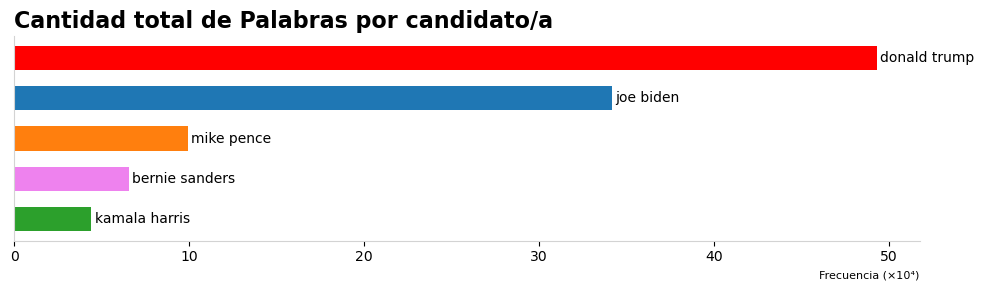

In [55]:
# Dividir los valores por 10,000 para la visualización
df_ordenado = df_palabras_por_orador.sort_values("cantidad_palabras", ascending=False)
df_ordenado["cantidad_palabras_escala"] = df_ordenado["cantidad_palabras"] / 10_000

fig, ax = plt.subplots(figsize=(10, 3))

# Gráfico con la nueva escala y barra más ancha
bars = ax.barh(
    df_ordenado['candidato'],
    df_ordenado['cantidad_palabras_escala'],
    height=0.6,  # Aumentado el grosor de las barras
    color=[color_map.get(c.lower(), 'gray') for c in df_ordenado['candidato']]
)

# Etiquetas con nombre del orador al final de cada barra
for i, bar in enumerate(bars):
    width = bar.get_width()
    nombre = df_ordenado.iloc[i]['candidato']
    ax.text(
        width + 0.2,
        bar.get_y() + bar.get_height() / 2,
        nombre,
        va='center',
        ha='left',
        fontsize=10         # Tamaño más grande
        # fontweight='bold'    # Texto en negrita
    )

# Título en grande y a la izquierda
ax.set_title(
    'Cantidad total de Palabras por candidato/a',
    fontsize=16,
    fontweight='bold',
    loc='left'
)

# Etiqueta del eje X indicando escala
ax.set_xlabel('Frecuencia (×10⁴)', fontsize=8, loc='right')

# Eliminar ticks del eje Y
ax.set_yticks([])

# Invertir eje Y para que el mayor esté arriba
ax.invert_yaxis()

# Mejorar estética
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_color('lightgray')

plt.tight_layout()
plt.show()


### Conteo total de palabras por candidato/a

#### Respuesta

Los candidatos/as con mayor cantidad de palabras acumuladas en los discursos son:

- **Donald Trump**
- **Joe Biden**
- **Mike Pence**
- **Bernie Sanders**
- **Kamala Harris**

#### Visualización del Gráfico 3: Conteo total de palabras por candidato/a

Esta visualización muestra claramente que:

- **Donald Trump** y **Joe Biden** son quienes más palabras pronunciaron.  Esto se explica porque son los candidatos con más apariciones y discursos acumulados.  
- **Kamala Harris** y **Mike Pence** tienen una participación menor tanto en frecuencia de palabras como en cantidad de menciones.

#### Dificultades encontradas para el conteo de palabras

Para poder contar correctamente las palabras por candidato/a, fue necesario:

1. Filtrar el dataframe solo con los discursos de los **top 5 candidatos**.
2. Para el **top 5 candidatos**, extraer las **intervenciones correspondientes a cada orador**, separando textos en las filas donde había más de un speaker.
3. **Limpiar y normalizar el texto**, eliminando todas las apariciones donde aparece el nombre del orador, para poder contar con precisión.

Este proceso fue necesario porque:

- Los textos originales contenían **intervenciones de múltiples oradores en la misma celda**.
- Los textos contenían las **palabras asociadas al nombre del orador** previo a cada línea de discurso.
- En algunos casos, el speaker referenciado en la columna no coincidía completamente con el contenido real del texto (había intervenciones mínimas de otras personas).

Sin esa separación y procesamiento previo, los conteos habrían sido **imprecisos**.

**Observación:**  
Al normalizar los nombres de algunos candidatos, se pasó en algunos casos de dos palabras a una (por ejemplo, *Trump* a *Donald Trump*), y este cambio no solo afectó al patrón detectado del encabezado tipo `'Nombre Apellido: (MM:SS)'`, sino también modificó las menciones dentro del cuerpo del discurso.  
Esto también pudo alterar levemente el conteo.

### C. Construya una matriz de 5x5, donde cada fi la y columna corresponden a un candiato/a, y la entrada (i,j) contiene la cantidad de veces que el candiato/a “i” menciona al candiato/a “j”. Opcional: genere un grafo dirigido con esa matriz de adyacencia para visualizar las menciones.

In [56]:
# TODO: Construya una matriz de 5x5, donde cada fila y columna corresponden a un candiato/a, 
# y la entrada (i,j) contiene la cantidad de veces que el candiato/a “i” menciona al candiato/a “j”.

# mentions_matrix = ...

In [57]:
# Inicializar matriz vacía
mentions_matrix = pd.DataFrame(
    data=np.zeros((5, 5), dtype=int),
    index=top_5_oradores,
    columns=top_5_oradores
)

# Llenar la matriz
for i, orador_i in enumerate(top_5_oradores):
    # Obtener lista de palabras del orador_i
    palabras = DISCURSOS_TOTALES.loc[i, 'WordList']
    texto_completo = " ".join(palabras).lower() if isinstance(palabras, list) else str(palabras).lower()

    # Contar menciones de cada otro orador
    for j, orador_j in enumerate(top_5_oradores):
        if orador_i != orador_j:
            menciones = texto_completo.count(orador_j)
            mentions_matrix.loc[orador_i, orador_j] = menciones

# Visualizar
print("Matriz de menciones entre candidatos:")
display(mentions_matrix)

Matriz de menciones entre candidatos:


,joe biden,donald trump,bernie sanders,mike pence,kamala harris
joe biden,0,623,6,0,13
donald trump,1071,0,51,38,12
bernie sanders,84,192,0,0,2
mike pence,477,620,8,0,60
kamala harris,111,110,0,4,0


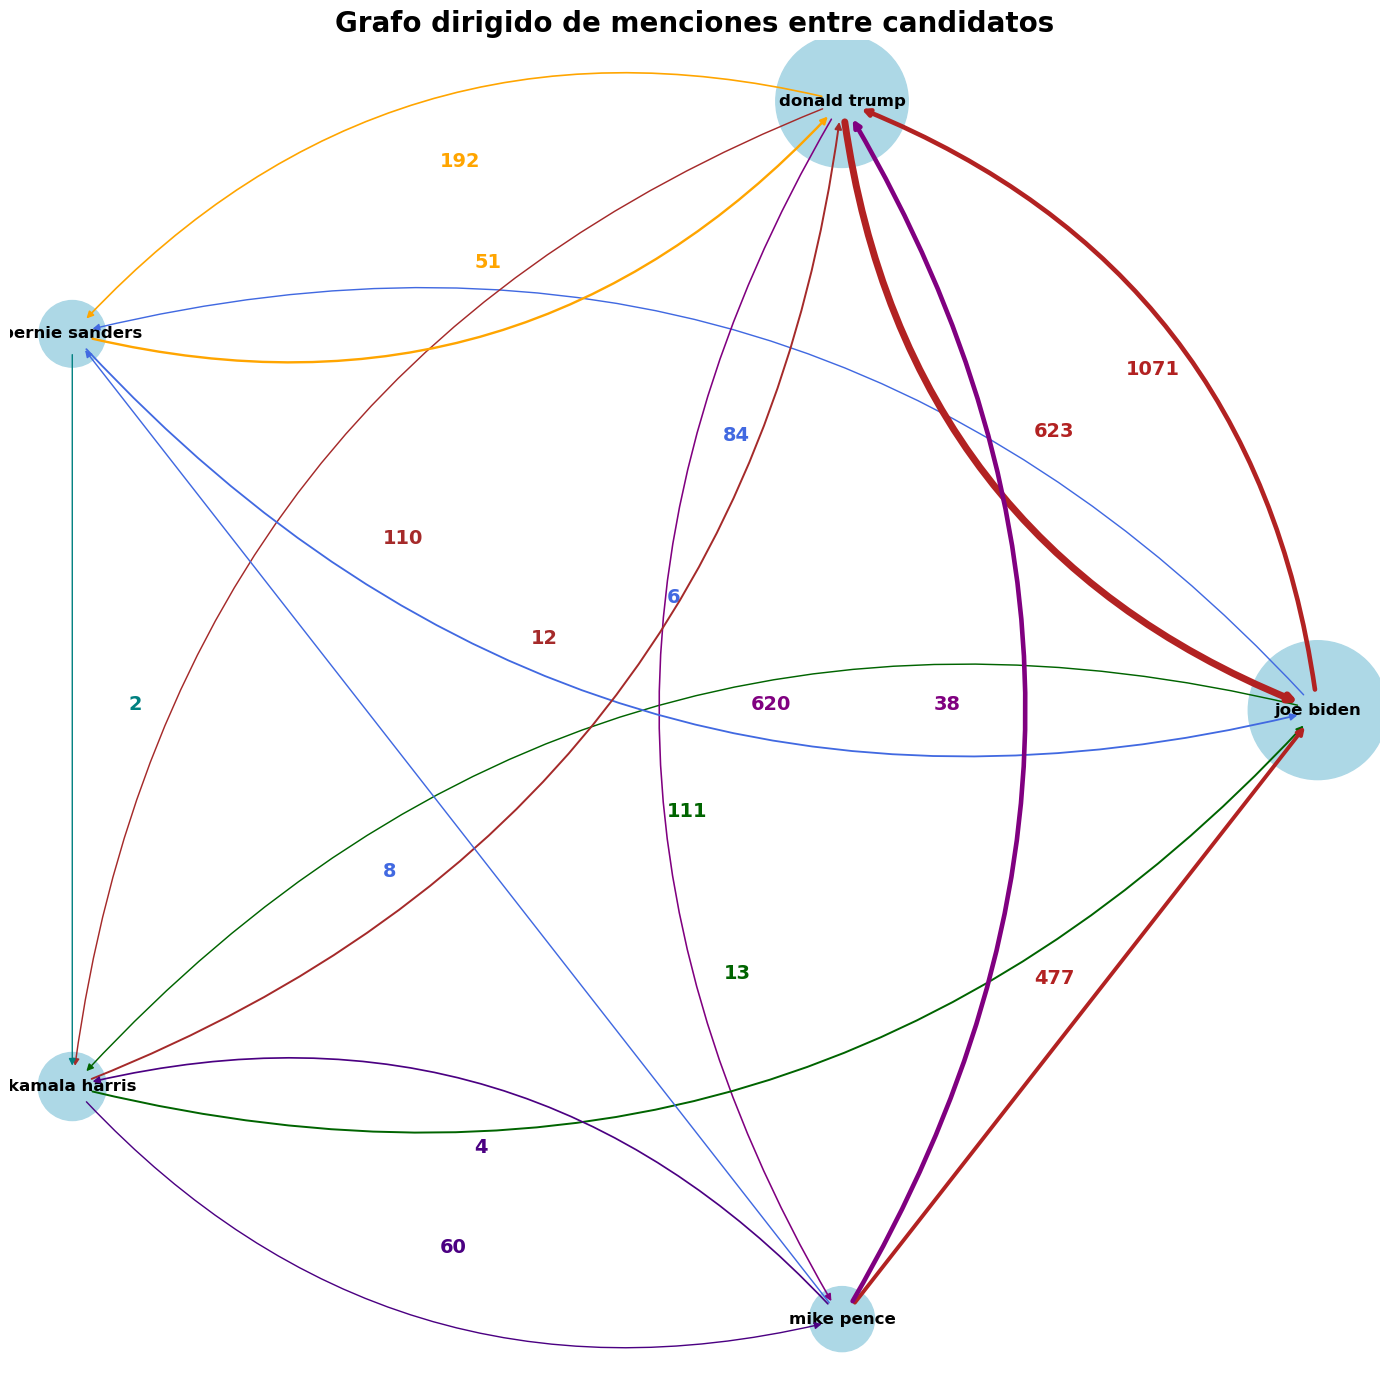

In [77]:
# # Opcional: Genere un grafo dirigido con esa matriz de adyacencia para visualizar las menciones. 
# # Puede ser util la biblioteca networkx

# Se genera un grafo dirigido que representa cuántas veces un candidato menciona a otro.  

# Crear un grafo dirigido
G = nx.DiGraph()

# Obtener la lista de candidatos (índices de la matriz)
candidatos = mentions_matrix.index.tolist()

# Agregar las aristas al grafo según la matriz de menciones
for source in candidatos:
    for target in candidatos:
        if source != target and mentions_matrix.loc[source, target] > 0:
            G.add_edge(source, target, weight=mentions_matrix.loc[source, target])

# Calcular la cantidad total de menciones recibidas por cada candidato (in-degree ponderado)
total_menciones_recibidas = {
    nodo: sum([d['weight'] for _, _, d in G.in_edges(nodo, data=True)])
    for nodo in G.nodes
}

# Normalizar tamaños de nodos para que no sean excesivos
max_menciones = max(total_menciones_recibidas.values()) if total_menciones_recibidas else 1
node_sizes = [
    2000 + 8000 * (total_menciones_recibidas[n] / max_menciones)
    for n in G.nodes
]

# Definir las posiciones de los nodos en un layout circular
pos = nx.circular_layout(G)
fig, ax = plt.subplots(figsize=(14, 14))

# Dibujar nodos con tamaño proporcional a las menciones recibidas
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', ax=ax)

# Dibujar etiquetas de los nodos
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', ax=ax)

# Crear un ciclo de colores para diferenciar los pares únicos de nodos
colores = itertools.cycle([
    'firebrick', 'royalblue', 'darkgreen', 'orange',
    'purple', 'brown', 'teal', 'indigo'
])

pares_coloreados = {}
for source, target in G.edges():
    key = tuple(sorted([source, target]))  # ordena para identificar el par único
    if key not in pares_coloreados:
        pares_coloreados[key] = next(colores)

# Dibujar flechas (aristas) con grosor proporcional al peso
for source, target in G.edges():
    weight = G.edges[source, target]['weight']
    color = pares_coloreados[tuple(sorted([source, target]))]
    is_reciprocal = G.has_edge(target, source) and source != target
    rad = 0.3 if is_reciprocal else 0.0

    # Escalar el grosor de la flecha
    lw = 1 + 4 * (weight / max(G.edges[edge]['weight'] for edge in G.edges))

    ax.annotate("",
        xy=pos[target], xycoords='data',
        xytext=pos[source], textcoords='data',
        arrowprops=dict(
            arrowstyle="-|>",
            color=color,
            shrinkA=15, shrinkB=15,
            connectionstyle=f"arc3,rad={rad}",
            lw=lw
        ),
    )

    # Mostrar el peso de la arista
    x1, y1 = pos[source]
    x2, y2 = pos[target]
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    offset = 0.07
    xm += - (y2 - y1) * offset
    ym += + (x2 - x1) * offset

    ax.text(xm, ym, str(weight), fontsize=14, color=color, fontweight='bold')

# Agregar título y ocultar ejes
plt.title("Grafo dirigido de menciones entre candidatos", fontsize=20, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

### D. Proponga al menos tres preguntas que se podrían intentar responder a partir de estos datos, y mencione posibles caminos para responderlas (sin implementar nada).

## Respuesta:

### 1. ¿Usan palabras diferentes segun la ubicación geográfica?

- Como mencionamos antes, usando la columna location, podríamos comparar si los candidatos adaptan su lenguaje según la audiencia.
- ¿Usan más palabras frecuentes como "trabajo" o "familia" en ciertos lugares? ¿Cambian el tono?
- Esto ayuda a ver si realmente intentan conectar con el público o si repiten lo mismo en todos lados.

### 2. ¿Qué tan fácil o difícil es entender lo que dicen?

- Se puede medir cuán complejo es el lenguaje de cada candidato: ¿usan frases largas o cortas? ¿palabras comunes o más técnicas?
- Hay fórmulas para medir legibilidad, que sirven para saber si están hablando "para todos" o si su discurso es más académico o técnico.
- Esto puede decir mucho sobre a quién están tratando de llegar.

### 3. ¿Qué tipo de palabras usan más? ¿Son más de acción o más descriptivos?

- Se puede analizar si cada candidato/a usa más verbos (acción), sustantivos (cosas, ideas) o adjetivos (descripciones).
- Es una forma de ver si están "haciendo promesas", "describiendo problemas" o "contando historias".

### 4. ¿Qué emociones predominan en los discursos?

- Aplicar análisis de sentimientos (positivo, negativo, neutro).
- Usar léxicos emocionales para identificar emociones específicas (miedo, alegría, enojo...).
- Comparar perfiles emocionales entre discursos, etapas o candidatos.